<a href="https://colab.research.google.com/github/justinngwaichung/US_Immigration_Analysis/blob/main/545proj_PERM_Prediction_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Big Data Analysis of US Immigration Applications

###Prediction Analysis of Permanent Employment Certification</h3>

Author: Zi Yi HE (Jackie), Wai Chung NG(Justin), Zhe Yi CHEN (Klaus)

Tips for Viewers:


*   *This notebook takes about 18 minutes to run.*
*   *The notebook has been run thoroughly upon submission, all results are displayed now.*
*   *Multiple interactive tools are used for visualization, which may sometimes cause latency in forming the plots. If any of the graph doesn't exhibit properly, simply rerunning the cell could resolve the issue.*




##Motivation
For a long time, immigration policy has been a key subject of political debate in the U.S. 
<br><br>
Some find it too "lenient" to immigration applicants, particularly for those in the tech industry, while some others cite long waiting times and a somewhat arbitrary screening process as barriers to retaining skilled labour through immigration.
<br><br>
Whatever people's stance may be, there seems to be one thing in common - that is the lack of data-driven analysis in supporting their claims for / against current U.S. immigration policies.
<br><br>
As international students ourselves, the U.S. work permit and permanent residency application system can come across as mystifying at times, let alone what constitutes a “successful” application which is even more complicated.
<br><br>
We believe a lot of fellow international students share the same concern. Through our analysis, we hope answer some of the following basic factual questions and ultimately help people better understand the immigration system that is in place.
- What are the most important determinants of a "successful" immigration application?
- What affects the "waiting time" of an application?
- Is there any noticeable variation in the success rate of applicants of different nationalities?
- Does computer science skills contribute to a higher salary and a higher chance of immigration approval, even if one is not working in the tech industry? 



##Summary of Key Takeaways

Our analysis primarily looks at the approval of <b>Permanent Employment Certification (PERM) applications</b>. PERM approval is necessary for a US permanent residency (commonly known as "Green Card") applications.

- On data exploratory level:
 - Firm size appears to be very positively correlated with PERM application approval.
 - Most PERM applications, certified or not, (unsurprisingly) comes from the state of California. Second in place is actually the state of Texas! A booming tech industry there... followed by the state of New York being third in place.
 - Having a degree is all that matters to your wages. Having a bachelor's versus a Master's versus a PhD doesn't make that much a difference, unless you have a JD or went to med school.
 - No evident discrimination based on previous citizenship.
 
- In predicting approval / denial of a PERM application:
 - Firm size (no. of employees), proposed wage relative to the prevailing wage of the sector, and education level of the applicant appears to be some of the most important determinants.
 - Random Forest model appears to yield the best prediction result (~97% accuracy) which is somewhat intuitive due to the large number of categorical variables inherent to our dataset.
 - Diving deep into individual variables (see section 4.2.4), we observe a seemingly high degree of arbitrariness of how PERM applications are adjudicated.



# Section 1: Environment Setup

We first set up our Google Colab as follows:
-  Starting by importing a number of useful libraries we use for data cleaning.
- Libaries for EDA and prediction analysis (e.g. `Scikit-learn`) will be imported along the way as needed.

In [ ]:
# setup toolkits
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np 
import re
import math
import random
import time
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
!pip install pandasql
import pandasql


  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=69043449b62adb3aa70b17551d85f856e2b2334a8686d7a53cb9e4230b3f230a
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


Here we import our data sources:
- All our data is hosted on google drive and we employ an external package called "gdown"
- The <b>core dataset</b> we are importing is <b>Permanent Employment Certification (PERM) application data</b> for 2018-2021. <p> In a nutshell, PERM is an application that all green card applicants would have to obtain from the Department of Labour (DoL) before they file their Immigrant Application (commonly known as "Green Card"). </p><p> The PERM data we import contains key information on individual applicants, such as education level, hiring company, geographical location, etc.
- In addition, we import <b>two supplemental datasets</b>:
 - <b>North American Industry Classification System (NAICS) data</b>, which would allow us to match the industry codes in our PERM data and understand which industry the filing company operates in
 - <b>Standard Occupation Classification (SOC) data</b>, which would allow us to match the occupation code in our PERM data and understand what occupation the applicant works in

In [ ]:
!pip install gdown
!gdown --id 1k8zK9u0jTpFJyyOUexkefjiYXoB0yjhC
!gdown --id 170rVuBdUsyHr2N2g9_giqdt2GBGCngqz
!gdown --id 1ftfE-K74d8hWJB1pON2oVT7sO6-1BYjw
!gdown --id 1HYo0SyLAotFuvVYefAtHRBOGxjE8HcQT
!gdown --id 1JDNbX0wQINoLuQPudTNZ2ysC9GjC4wHW
!gdown --id 1BDRpM9MFN1-mw8rB8bCb1aYDJq2ecqn2

Downloading...
From: https://drive.google.com/uc?id=1k8zK9u0jTpFJyyOUexkefjiYXoB0yjhC
To: /content/perm_2021.csv
100% 195M/195M [00:01<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=170rVuBdUsyHr2N2g9_giqdt2GBGCngqz
To: /content/perm_2020.csv
100% 169M/169M [00:01<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ftfE-K74d8hWJB1pON2oVT7sO6-1BYjw
To: /content/perm_2019.csv
100% 98.0M/98.0M [00:00<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HYo0SyLAotFuvVYefAtHRBOGxjE8HcQT
To: /content/perm_2018.csv
100% 111M/111M [00:01<00:00, 103MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1JDNbX0wQINoLuQPudTNZ2ysC9GjC4wHW
To: /content/naics_reference.csv
100% 108k/108k [00:00<00:00, 39.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BDRpM9MFN1-mw8rB8bCb1aYDJq2ecqn2
To: /content/soc_reference.csv
100% 70.6k/70.6k [00:00<00:00, 39.3MB/s]


# Section 2: Data Cleaning and Wrangling


##2.1 Overview of Data Cleaning

- The very first step is to clean our data in to the format we need.

- Each fiscal year's publicized record layout varies in terms of its column naming and columns numbers.

- For instance, while data from 2018 and 2019 contain by and large the same number of features, 2020 and 2021 records tend to contain more features. Therefore we have decided to clean each of the 4 years data separately, then append them together.

- We start off with 2021 data to illustrate some high-level decisions we make, and then proceed with the detailed cleaning of each year's data.

In [ ]:
# read csv files
raw_2021 = pd.read_csv("/content/perm_2021.csv", low_memory=False)
# dropna by setting how = "all" since pandas sometimes will read empty lines as NaN at the end of the csv
raw_2021 = raw_2021.dropna(how="all")

We can print out each fiscal year's number of applications to get a sense of how large the datasets are, as well as the no. of columns in our dataset.

For speed's sake, we will only do so for the 2021 dataset for now, and leave the other years to the later part of the cleaning process.

In a nutshell, there is roughly 100,000 data points each fiscal year. Column-wise, there is a total of 125 columns in the 2018 and 2019 data, and 154 columns in the 2020 and 2021 data.

In [ ]:
# raw_2020 = pd.read_csv("/content/perm_2020.csv")
# raw_2020 = raw_2020.dropna(how="all")
# raw_2019 = pd.read_csv("/content/perm_2019.csv")
# raw_2019 = raw_2019.dropna(how="all")
# raw_2018 = pd.read_csv("/content/perm_2018.csv")
# raw_2018 = raw_2018.dropna(how="all")

# print(len(raw_2018.columns))
# print(len(raw_2019.columns))
# print(len(raw_2020.columns))

print("No. of rows in 2021 raw dataset:", len(raw_2021))
print("No. of columns in 2021 raw dataset:", len(raw_2021.columns))

No. of rows in 2021 raw dataset: 108264
No. of columns in 2021 raw dataset: 154


The full list of columns for the 2021 data are printed out below. For the purpose of predicting the approval / denial decision of a PERM application, we would probably want to filter a number of "useful" columns.

In [ ]:
raw_2021.columns.values

array(['CASE_NUMBER', 'CASE_STATUS', 'RECEIVED_DATE', 'DECISION_DATE',
       'REFILE', 'ORIG_FILE_DATE', 'PREVIOUS_SWA_CASE_NUMBER_STATE',
       'SCHD_A_SHEEPHERDER', 'EMPLOYER_NAME', 'EMPLOYER_ADDRESS_1',
       'EMPLOYER_ADDRESS_2', 'EMPLOYER_CITY', 'EMPLOYER_STATE_PROVINCE',
       'EMPLOYER_COUNTRY', 'EMPLOYER_POSTAL_CODE', 'EMPLOYER_PHONE',
       'EMPLOYER_PHONE_EXT', 'EMPLOYER_NUM_EMPLOYEES',
       'EMPLOYER_YEAR_COMMENCED_BUSINESS', 'NAICS_CODE',
       'FW_OWNERSHIP_INTEREST', 'EMP_CONTACT_NAME',
       'EMP_CONTACT_ADDRESS_1', 'EMP_CONTACT_ADDRESS_2',
       'EMP_CONTACT_CITY', 'EMP_CONTACT_STATE_PROVINCE',
       'EMP_CONTACT_COUNTRY', 'EMP_CONTACT_POSTAL_CODE',
       'EMP_CONTACT_PHONE', 'EMP_CONTACT_EMAIL', 'AGENT_ATTORNEY_NAME',
       'AGENT_ATTORNEY_FIRM_NAME', 'AGENT_ATTORNEY_PHONE',
       'AGENT_ATTORNEY_PHONE_EXT', 'AGENT_ATTORNEY_ADDRESS_1',
       'AGENT_ATTORNEY_ADDRESS_2', 'AGENT_ATTORNEY_CITY',
       'AGENT_ATTORNEY_STATE_PROVINCE', 'AGENT_ATTORNEY_COUNTRY

For speed and interpretability, we filter out many columns in the following step that are not helpful in predicting case result or redundant, and only keep those that are interesting to explore.
<br><br>
Some of the key variables we have chosen are:
- Date of application receipt (by DoL) and date of decision issuance

- Employer information (company name, employee size, location (country, state, and city))
- Industry (`NAICS_CODE`), Occupation (`SOC_CODE`), and Job title (e.g.: One can be a data analyst in the retail industry vs a data analyst in a tech firm, in which case `SOC_CODE` would be the same but not the `NAICS_CODE`)
- Proposed wage for the applicant, and the prevailing wage of the applicant's occupation as determined by the US Government
- Applicants' background information (education level, major, skills, current visa status)


In [ ]:
# put the features we are interested and useful into a list
columns_2021 = ['CASE_NUMBER','CASE_STATUS','RECEIVED_DATE','DECISION_DATE','EMPLOYER_NAME','EMPLOYER_CITY','EMPLOYER_COUNTRY','EMPLOYER_STATE_PROVINCE','EMPLOYER_NUM_EMPLOYEES','NAICS_CODE','PW_SOC_CODE','FW_OWNERSHIP_INTEREST',
'PW_SOC_TITLE','PW_SKILL_LEVEL','PW_WAGE','PW_UNIT_OF_PAY','WAGE_OFFER_FROM','WAGE_OFFER_TO','WAGE_OFFER_UNIT_OF_PAY','WORKSITE_CITY','WORKSITE_STATE','WORKSITE_POSTAL_CODE','JOB_TITLE','SPECIFIC_SKILLS','COUNTRY_OF_CITIZENSHIP','CLASS_OF_ADMISSION','FOREIGN_WORKER_EDUCATION','FOREIGN_WORKER_INFO_MAJOR']

len(columns_2021)

28

##2.2 Cleaning of 2021 Data

In [ ]:
perm21_df = raw_2021[columns_2021] # read in dataframe with selected columns

In [ ]:
perm21_df.head(10) # print to get a rough sense of how the dataframe looks like

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_COUNTRY,EMPLOYER_STATE_PROVINCE,EMPLOYER_NUM_EMPLOYEES,NAICS_CODE,PW_SOC_CODE,FW_OWNERSHIP_INTEREST,PW_SOC_TITLE,PW_SKILL_LEVEL,PW_WAGE,PW_UNIT_OF_PAY,WAGE_OFFER_FROM,WAGE_OFFER_TO,WAGE_OFFER_UNIT_OF_PAY,WORKSITE_CITY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,JOB_TITLE,SPECIFIC_SKILLS,COUNTRY_OF_CITIZENSHIP,CLASS_OF_ADMISSION,FOREIGN_WORKER_EDUCATION,FOREIGN_WORKER_INFO_MAJOR
0,A-19178-24147,Withdrawn,6/27/2019,10/1/2020,Ennovaco Corp,Miami,UNITED STATES OF AMERICA,FLORIDA,6.0,541613,43-3031,N,Bookkeeper,Level III,"$40,227.00",Year,"$40,227.00",NaN,Year,Miami,FLORIDA,33166,Bookkeeper,NaN,VENEZUELA,B-2,Bachelor's,INDUSTRIAL RELATIONS
1,A-19198-32049,Denied,7/17/2019,10/1/2020,"CAPGEMINI AMERICA, INC.",CHICAGO,UNITED STATES OF AMERICA,ILLINOIS,14000.0,541511,15-1132,N,"Software Developers, Applications",Level III,"$96,658.00",Year,"$97,000.00","$148,000.00",Year,Chicago,ILLINOIS,60606,Manager,Must have experience with each of the followin...,INDIA,H-1B,Bachelor's,ELECTRONICS AND COMMUNICATION ENGINEERING
2,A-19224-43106,Certified-Expired,12/16/2019,10/1/2020,APPLE INC.,CUPERTINO,UNITED STATES OF AMERICA,CALIFORNIA,137000.0,334111,15-1133,N,"Software Developers, Systems Software",Level I,"$96,325.00",Year,"$146,000.00","$170,400.00",Year,Cupertino,CALIFORNIA,95014,Software Development Engineer,The position requires a Bachelors degree or fo...,CHINA,H-1B,Bachelor's,COMPUTER ENGINEERING
3,A-19248-53820,Certified-Expired,12/16/2019,10/1/2020,APPLE INC.,CUPERTINO,UNITED STATES OF AMERICA,CALIFORNIA,132000.0,334111,17-2072,N,"Electronics Engineers, Except Computer",Level II,"$111,634.00",Year,"$134,888.00","$170,400.00",Year,Cupertino,CALIFORNIA,95014,ASIC Design Engineer,The position requires a Masters degree or fore...,SOUTH KOREA,H-1B,Doctorate,COMPUTER ENGINEERING
4,A-19252-55077,Certified-Expired,12/11/2019,10/1/2020,AON BENFIELD INC.,CHICAGO,UNITED STATES OF AMERICA,ILLINOIS,50000.0,5241,15-2011,N,Actuaries,Level IV,"$122,138.00",Year,"$190,000.00",NaN,Year,Chicago,ILLINOIS,60601,Director - Actuarial & Analytics,"Bachelors degree in Actuarial Science, Mathema...",UNITED KINGDOM,H-1B,Bachelor's,MATHEMATICS
5,A-19268-63027,Certified-Expired,12/24/2019,10/1/2020,APPLE INC.,CUPERTINO,UNITED STATES OF AMERICA,CALIFORNIA,137000.0,334111,17-2072,N,"Electronics Engineers, Except Computer",Level II,"$111,634.00",Year,"$146,000.00","$173,300.00",Year,Cupertino,CALIFORNIA,95014,Hardware Development Engineer,This position requires a Masters degree or for...,CHINA,H-1B,Master's,AERONAUTICS AND ASTRONAUTICS
6,A-19276-66232,Certified-Expired,11/19/2019,10/1/2020,"TWITTER, INC.",SAN FRANCISCO,UNITED STATES OF AMERICA,CALIFORNIA,1811.0,541511,15-1132,N,"Software Developers, Applications",Level I,"$94,203.00",Year,"$156,450.00",NaN,Year,San Francisco,CALIFORNIA,94103,Site Reliability Engineer II,1. Distributed Systemsbr 2. Operating Systemsb...,CANADA,TN,Bachelor's,COMPUTER ENGINEERING
7,A-19278-67143,Certified-Expired,11/18/2019,10/1/2020,U.S. BANK NATIONAL ASSOCIATION,MINNEAPOLIS,UNITED STATES OF AMERICA,MINNESOTA,74000.0,521110,15-1142,N,Network and Computer Systems Administrators,Level IV,"$95,742.00",Year,"$95,742.00",NaN,Year,Gresham,OREGON,97230,AEM Administrator,Requires a Bachelors degree in Computer Scienc...,INDIA,H-1B,Bachelor's,INFORMATION TECHNOLOGY
8,A-19280-67307,Certified-Expired,12/20/2019,10/1/2020,"BAIN COMPANY, INC",BOSTON,UNITED STATES OF AMERICA,MASSACHUSETTS,3900.0,541611,13-1111,N,Management Analysts,Level III,"$116,189.00",Year,"$185,000.00","$225,000.00",Year,New York,NEW YORK,10036,Manager,Experience must include valuation of product l...,INDIA,H-1B,Master's,BUSINESS ADMINISTRATION
9,A-19280-67686,Certified-Expired,11/4/2019,10/1/2020,Turn Key Systems Incorporated,Martinez,UNITED STATES OF AMERICA,CALIFORNIA,1.0,2389,11-1021,N,General Manager,Level I,"$69,368.00",Year,"$69,500.00","$80,000.00",Year,Martinez,CALIFORNIA,94553,General Mana

Rename all the columns to more concise and comprehensive ones in lowercases in the cell below.

In [ ]:
perm21_df = perm21_df.rename(columns= {'CASE_NUMBER':'case_id','CASE_STATUS':'status','RECEIVED_DATE':'received_date',
                                       'DECISION_DATE':'decision_date','EMPLOYER_NAME':'employer_name',
                                       'EMPLOYER_CITY':'employer_city','EMPLOYER_COUNTRY':'employer_country',
                                       'EMPLOYER_STATE_PROVINCE':'employer_state','EMPLOYER_NUM_EMPLOYEES':'employee_size',
                                       'NAICS_CODE':'industry_code','PW_SOC_CODE':'soc_code','PW_SOC_TITLE':'soc_title',
                                       'PW_SKILL_LEVEL':'skill_level','PW_WAGE':'pw','PW_UNIT_OF_PAY':'pw_unit',
                                       'WAGE_OFFER_FROM':'wage_from','WAGE_OFFER_TO':'wage_to',
                                       'WAGE_OFFER_UNIT_OF_PAY':'prop_unit','WORKSITE_CITY':'work_city','WORKSITE_STATE':'work_state',
                                       'WORKSITE_POSTAL_CODE':'work_postcode','JOB_TITLE':'job_title','SPECIFIC_SKILLS':'special_skills',
                                       'COUNTRY_OF_CITIZENSHIP':'home_country','CLASS_OF_ADMISSION':'curr_visa',
                                       'FOREIGN_WORKER_EDUCATION':'education','FOREIGN_WORKER_INFO_MAJOR':'major',
                                       'FW_OWNERSHIP_INTEREST':'ownership'})
# there are instances where 'wage_to' :maximum proposed wage is null, but for more precise wage calculation later, we tend to keep it if it is null 
perm21_df['wage_to'] = perm21_df['wage_to'].fillna('0')
# dropna and duplicate rows
perm21_df.dropna(inplace=True)
print("rows before dropping duplicates: ", len(perm21_df))
perm21_df.drop_duplicates(subset=['case_id'],inplace=True)
print("rows after dropping case_id duplicates: ", len(perm21_df))

rows before dropping duplicates:  83355
rows after dropping case_id duplicates:  83355


In [ ]:
perm21_df.dtypes # check to see datatypes

case_id              object
status               object
received_date        object
decision_date        object
employer_name        object
employer_city        object
employer_country     object
employer_state       object
employee_size       float64
industry_code        object
soc_code             object
ownership            object
soc_title            object
skill_level          object
pw                   object
pw_unit              object
wage_from            object
wage_to              object
prop_unit            object
work_city            object
work_state           object
work_postcode        object
job_title            object
special_skills       object
home_country         object
curr_visa            object
education            object
major                object
dtype: object

We can see that the majority of featrues are in string so far. So in the following we convert numerical features stored in string format into suitable datatype (e.g., float for `wage_from`, `wage_to`, datetime for `received_date`) and strip columns that would continue to exist in string format.

In [ ]:
# clean date types
# date and time
perm21_df['received_date'] = pd.to_datetime(perm21_df['received_date'],format='%m/%d/%Y')
perm21_df['decision_date'] = pd.to_datetime(perm21_df['decision_date'],format= "%m/%d/%Y")
perm21_df['employee_size'] = perm21_df['employee_size'].astype('int')
# string currency into float
perm21_df['pw'] = perm21_df['pw'].apply(lambda x: x.lstrip("$")).apply(lambda x: x.replace(",","")).astype('float')
perm21_df['wage_from'] = perm21_df['wage_from'].apply(lambda x: x.lstrip("$")).apply(lambda x: x.replace(",","")).astype('float')
perm21_df['wage_to'] = perm21_df['wage_to'].apply(lambda x: x.lstrip("$")).apply(lambda x: x.replace(",","")).astype('float')
# strip whitespaces at the ends of a string for object columns
perm21_df['employer_name'] = perm21_df['employer_name'].apply(lambda x: x.strip())
perm21_df['employer_city'] = perm21_df['employer_city'].apply(lambda x: x.strip())
perm21_df['employer_country'] = perm21_df['employer_country'].apply(lambda x: x.strip())
perm21_df['employer_state'] = perm21_df['employer_state'].apply(lambda x: x.strip())
perm21_df['soc_title'] = perm21_df['soc_title'].apply(lambda x: x.strip())
perm21_df['work_state'] = perm21_df['work_state'].apply(lambda x: x.strip())
perm21_df['work_city'] = perm21_df['work_city'].apply(lambda x: x.strip())
perm21_df['job_title'] = perm21_df['job_title'].apply(lambda x: x.strip())
perm21_df['home_country'] = perm21_df['home_country'].apply(lambda x: x.strip())
perm21_df['major'] = perm21_df['major'].apply(lambda x: x.strip())
# print to check changes successful or not
print(perm21_df.dtypes)

case_id                     object
status                      object
received_date       datetime64[ns]
decision_date       datetime64[ns]
employer_name               object
employer_city               object
employer_country            object
employer_state              object
employee_size                int64
industry_code               object
soc_code                    object
ownership                   object
soc_title                   object
skill_level                 object
pw                         float64
pw_unit                     object
wage_from                  float64
wage_to                    float64
prop_unit                   object
work_city                   object
work_state                  object
work_postcode               object
job_title                   object
special_skills              object
home_country                object
curr_visa                   object
education                   object
major                       object
dtype: object


We noticed that some categorical columns `status`, `skill_level`, `pw_unit`, `prop_unit`, `curr_visa`, `education` have a relatively small amount of unique values. We will implement some mappings for columns like `skill_level`, `pw_unit`, etc. to generate standard measure in numerical values.

In [ ]:
print('status: ',perm21_df['status'].unique())
print('skill_level: ',perm21_df['skill_level'].unique())
print('pw_unit: ',perm21_df['pw_unit'].unique())
print('prop_unit: ',perm21_df['prop_unit'].unique())
print('curr_visa: ',perm21_df['curr_visa'].unique())
print('education: ',perm21_df['education'].unique())

status:  ['Denied' 'Certified-Expired' 'Withdrawn' 'Certified']
skill_level:  ['Level III' 'Level I' 'Level II' 'Level IV']
pw_unit:  ['Year' 'Hour' 'Bi-Weekly' 'Month' 'Week']
prop_unit:  ['Year' 'Hour' 'Month' 'Week' 'Bi-Weekly']
curr_visa:  ['H-1B' 'TN' 'Not in USA' 'F-1' 'I' 'L-1' 'J-1' 'B-2' 'O-1' 'H-4' 'E-3'
 'Parolee' 'E-2' 'F-2' 'L-2' 'R-1' 'H-2B' 'EWI' 'H-1A' 'VWT' 'H-1B1' 'E-1'
 'A1/A2' 'J-2' 'TPS' 'B-1' 'H-2A' 'G-4' 'C-1' 'P-1' 'H-3' 'A-3' 'O-3'
 'G-1' 'D-1' 'G-5' 'CW-1' 'C-3' 'VWB' 'O-2' 'R-2' 'TD']
education:  ["Bachelor's" 'Doctorate' "Master's" 'High School' 'Other' "Associate's"
 'None']


In the cell below, we transform wage information to a uniform measuring unit (aka $/year) since we have various unit measures such as week, bi-weekly, month, and year. In the United States, a person has 48 working weeks in a year on average, and 40 hours per week for a full-time job. In a whole year, that's 48 weeks in total or 1920 hours in total, leading to a dictionary map of `pw_unit_code = {'Year':1, 'Hour': 1920, 'Bi-Weekly':24, 'Month':12}`.

In [ ]:
# generate waiting time features wait_days (int)
perm21_df[['wait_days']] = (perm21_df['decision_date'] - perm21_df['received_date']).astype('str').apply(lambda x: x.replace(" days",""))
perm21_df[['wait_days']] = perm21_df[['wait_days']].astype("int")
# title string features for better formatting
perm21_df['employer_name'] = perm21_df['employer_name'].apply(lambda x: x.title())
perm21_df['employer_city'] = perm21_df['employer_city'].apply(lambda x: x.title())
perm21_df['employer_country'] = perm21_df['employer_country'].apply(lambda x: x.title())
perm21_df['employer_state'] = perm21_df['employer_state'].apply(lambda x: x.title())
perm21_df['work_state'] = perm21_df['work_state'].apply(lambda x: x.title())
perm21_df['work_city'] = perm21_df['work_city'].apply(lambda x: x.title())
perm21_df['home_country'] = perm21_df['home_country'].apply(lambda x: x.title())
perm21_df['major'] = perm21_df['major'].apply(lambda x: x.title())
# transfrom skill_level to numerical expression in new column skill_level2
level_code = {'Level III':3, 'Level I':1, 'Level II':2, 'Level IV':4}
perm21_df[['skill_level2']] =perm21_df['skill_level'].map(level_code)
# make prevailing wages (time-measuring) unit consistent
# In the United States, a person has 48 working weeks in a year on average, and 40 hours per week for a full-time job
# In one year, that's 48 weeks in total, 1920 hours in total
pw_unit_code = {'Year':1, 'Hour': 1920, 'Bi-Weekly':24, 'Month':12}
perm21_df['pw_multiplier'] =  perm21_df['pw_unit'].map(pw_unit_code)
perm21_df['pw_yearly'] = perm21_df['pw']*perm21_df['pw_multiplier']
# similar transformation for porposed wage
# if the wage_to is not 0, which we use to fill null in 'wage_to' before, we calculate the mean of wage_from and wage_to as the final proposed wage
def final_wage(row):
  if row['wage_to'] > 0:
    return (row['wage_from'] + row['wage_to'] )/2             # wage_to is not null/0
  else:
    return row['wage_from']
perm21_df['proposed_wage'] = perm21_df.apply(lambda x: final_wage(x), axis=1) 
prop_unit_code = {'Year':1, 'Hour': 1920, 'Bi-Weekly':24, 'Month':12}
perm21_df['prop_multiplier'] =  perm21_df['prop_unit'].map(prop_unit_code)
perm21_df['prop_yearly'] = perm21_df['proposed_wage']*perm21_df['prop_multiplier']
# drop intermediate featrues that become helpless after this step
perm21_df = perm21_df.drop( columns=['prop_multiplier','proposed_wage','pw_multiplier','prop_unit','pw_unit','pw','wage_from','wage_to'])

In [ ]:
# extract year and month information to seperate columns
perm21_df['year'] = perm21_df['decision_date'].dt.year
perm21_df['month'] = perm21_df['decision_date'].dt.month
perm21_df['received_year'] = perm21_df['received_date'].dt.year
perm21_df['received_month'] = perm21_df['received_date'].dt.month

Now we also have a Standard Ocuupational Classification 2018 Structure CSV file from U.S. Bureau of Labor Statistics: https://www.bls.gov/soc/2018/#classification
  
We need to clean it to join it with our primary dataset, so we have a more standard measure of the occupational names of applicants. Here, we will use detailed occupation code xx-xxxx for all instances.


In [ ]:
soc_raw_df = pd.read_csv("/content/soc_reference.csv")
soc_raw_df.head(10) # print to see the raw data

,major_group,minor_group,broad_group,detailed_occupation,occupation_name
0,11-0000,NaN,NaN,NaN,Management Occupations
1,NaN,11-1000,NaN,NaN,Top Executives
2,NaN,NaN,11-1010,NaN,Chief Executives
3,NaN,NaN,NaN,11-1011,Chief Executives
4,NaN,NaN,11-1020,NaN,General and Operations Managers
5,NaN,NaN,NaN,11-1021,General and Operations Managers
6,NaN,NaN,11-1030,NaN,Legislators
7,NaN,NaN,NaN,11-1031,Legislators
8,NaN,11-2000,NaN,NaN,"Advertising, Marketing, Promotions, Public Rel..."
9,NaN,NaN,11-2010,NaN,Advertising and Promotions Managers


In [ ]:
# filter our rows where detailed_group is not null
detailed_occupation_df = soc_raw_df.dropna(subset = ["detailed_occupation"], how = 'any', inplace=False) # by default inplace = False
# filter our rows where major_group is not null
major_group_df = soc_raw_df.dropna(subset=["major_group"])
# filter our rows where minor_group is not null
minor_group_df = soc_raw_df.dropna(subset=["minor_group"])
# filter our rows where broad_group is not null
broad_group_df = soc_raw_df.dropna(subset=["broad_group"])

In [ ]:
# unifying the column names to soc_code and occupation_name
detailed = detailed_occupation_df[["detailed_occupation","occupation_name"]].rename(columns = {"detailed_occupation": "soc_code"})
major = major_group_df[["major_group", "occupation_name"]].rename(columns = {"major_group": "soc_code"})
minor = minor_group_df[["minor_group", "occupation_name"]].rename(columns = {"minor_group": "soc_code"})
broad = broad_group_df[["broad_group", "occupation_name"]].rename(columns = {"broad_group" : "soc_code"})

In [ ]:
# print to check intermediate results
print(major.head(5))
print(minor.head(5))
print(detailed.head(5))
print(broad.head(5))

    soc_code                                 occupation_name
0    11-0000                          Management Occupations
73   13-0000   Business and Financial Operations Occupations
134  15-0000           Computer and Mathematical Occupations
170  17-0000        Architecture and Engineering Occupations
231  19-0000  Life, Physical, and Social Science Occupations
   soc_code                                    occupation_name
1   11-1000                                     Top Executives
8   11-2000  Advertising, Marketing, Promotions, Public Rel...
17  11-3000                    Operations Specialties Managers
37  11-9000                       Other Management Occupations
74  13-1000                    Business Operations Specialists
   soc_code                      occupation_name
3   11-1011                     Chief Executives
5   11-1021      General and Operations Managers
7   11-1031                          Legislators
10  11-2011  Advertising and Promotions Managers
12  11-2021

In [ ]:
# concatenate above four dfs and sort by the soc_code
soc_cleaned = detailed.append(major, ignore_index= True).append(minor, ignore_index = True).append(broad, ignore_index = True)
soc_cleaned = soc_cleaned.sort_values("soc_code", ascending= True)
# reset_index
soc_cleaned = soc_cleaned.reset_index(drop=True) # do not include previous index as a columns by setting drop = True
print(soc_cleaned)

     soc_code                                    occupation_name
0     11-0000                             Management Occupations
1     11-1000                                     Top Executives
2     11-1010                                   Chief Executives
3     11-1011                                   Chief Executives
4     11-1020                    General and Operations Managers
...       ...                                                ...
1442  55-3014                 Artillery and Missile Crew Members
1443  55-3015             Command and Control Center Specialists
1444  55-3016                                           Infantry
1445  55-3018                                     Special Forces
1446  55-3019  Military Enlisted Tactical Operations and Air/...

[1447 rows x 2 columns]


From this step of cleaning the soc_code reference book. We can learn that basically there are 1447 standard classifications for occupations. There are 23 major categories of professions, such as Management Occupations, Computer and Mathematical Occupations, Legal Occupations, Educational Instruction and Library Occupations, Farming, Fishing, and Forestry Occupations, etc., while each of these major groups contains more comprehensive branch categories.

In [ ]:
soc_cleaned.dtypes # soc_code and occupation name are all in string so far
soc_cleaned[['soc_code']] = soc_cleaned[['soc_code']].astype("str")
soc_cleaned[['soc_code']] = soc_cleaned[['soc_code']].apply(lambda x: x.str.strip())
soc_cleaned['occupation_name'] = soc_cleaned['occupation_name'].astype("str").apply(lambda x: x.strip())
# make sure all values in sco_code from perm21_df are also string
perm21_df['soc_code'] = perm21_df[['soc_code']].astype("str")
perm21_df['soc_code'] = perm21_df[['soc_code']].apply(lambda x: x.str.strip())

In [ ]:
# join soc_cleaned with perm21_df to get standard occupational name
perm21_soc_df = perm21_df.merge(soc_cleaned, on="soc_code", how="left")

Joined with soc_cleand, perm21_soc_df seems to have a large amount of null values in occupation_name, indicating that the soc_code in perm21_df is not sufficiently normative perhaps due to typos or not referencing the most up to date SOC CODE Structure. Nevertheless, we don't want to lose 50k+ observations by simply dropping rows with null. Instead, because the pursuit of standard occupation_name is desired for forming more concise and uniform visualization, we decide to fill null occupation_name with `soc_title` to avoid reducing our sample size enormously. 

In [ ]:
# check null values after left join
print(perm21_soc_df.isnull().sum())
print("unique # of soc_title:", perm21_soc_df['soc_title'].nunique())
print("unique # of occupation_name before fillna:", perm21_soc_df['occupation_name'].nunique())

case_id                 0
status                  0
received_date           0
decision_date           0
employer_name           0
employer_city           0
employer_country        0
employer_state          0
employee_size           0
industry_code           0
soc_code                0
ownership               0
soc_title               0
skill_level             0
work_city               0
work_state              0
work_postcode           0
job_title               0
special_skills          0
home_country            0
curr_visa               0
education               0
major                   0
wait_days               0
skill_level2            0
pw_yearly               1
prop_yearly            12
year                    0
month                   0
received_year           0
received_month          0
occupation_name     54235
dtype: int64
unique # of soc_title: 4211
unique # of occupation_name before fillna: 442


In [ ]:
# though fillna with soc_title, 'occupation_name' still has less unique # of values than 'soc_title' 
perm21_soc_df['occupation_name'] = perm21_soc_df['occupation_name'].fillna(perm21_soc_df['soc_title'])
print("unique # of occupation_name after fillna:", perm21_soc_df['occupation_name'].nunique())
perm21_soc_df = perm21_soc_df.dropna() # drop na for 13 rows either pw_yearly or prop_yearly is null

unique # of occupation_name after fillna: 1865


Next, another join based on the NAICS (North American Industry Classification System) CODE with cleaned `naics_code` reference will enable us to get the name of the industry that the employer is associated with. 
Reference source of NAICS Structure can be found at https://www.census.gov/naics/?48967

In [ ]:
# read reference table to naics_df
naics_df = pd.read_csv("/content/naics_reference.csv")
print(naics_df.dtypes)
naics_df = naics_df.drop(columns = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"])
naics_df = naics_df.astype(str)
naics_cleaned = naics_df.apply(lambda x: x.str.strip())
naics_cleaned

naics_code        object
industry_name     object
Unnamed: 2       float64
Unnamed: 3        object
Unnamed: 4        object
dtype: object


,naics_code,industry_name
0,11,"Agriculture, Forestry, Fishing and Hunting"
1,111,Crop Production
2,1111,Oilseed and Grain Farming
3,11111,Soybean Farming
4,111110,Soybean Farming
...,...,...
2191,9281,National Security and International Affairs
2192,92811,National Security
2193,928110,National Security
2194,92812,International Affairs


It is worth pointing out that on a higher-most level, `naics_code` is only represented in 2 digits. They are further split down into "children" categories in 3 / 4 / 5 / 6 digits in length. The longer the `naics_code`, the further down the tree the industry is.

Balancing level of detail and generalizability, we have decided to opt for `naics_code` that are 3 digits long, which would give us 99 industries in total.

In [ ]:
# additional code to "dumb down" the naics_code
naics_cleaned = naics_cleaned[naics_cleaned['naics_code'].apply(lambda x: len(x) == 3)]
naics_cleaned

,naics_code,industry_name
1,111,Crop Production
55,112,Animal Production and Aquaculture
97,113,Forestry and Logging
107,114,"Fishing, Hunting and Trapping"
116,115,Support Activities for Agriculture and Forestry
...,...,...
2162,924,Administration of Environmental Quality Programs
2168,925,"Administration of Housing Programs, Urban Plan..."
2174,926,Administration of Economic Programs
2186,927,Space Research and Technology


In subsequent cells, joining with 'naics_cleaned' is completed and  perm21_joined_df is the finalized cleaned data of 2021. 

In [ ]:
# some industry_code are in float format ,such as '3275767.0', thus cannot be recognized, here is the transformation
industry_arr = np.array(perm21_soc_df['industry_code'].to_list())
industry_code_numeric = pd.to_numeric(industry_arr,errors='coerce')
industry_code_cleaned = industry_code_numeric.astype(int)
industry_code_cleaned_df = pd.DataFrame(industry_code_cleaned, columns=["industry_code_cleaned"])

In [ ]:
# add on industry_code_cleaned
perm21_soc_df[['industry_code_cleaned']] = industry_code_cleaned_df[['industry_code_cleaned']].copy().astype("str")
# drop dirty industry_code
perm21_soc_df = perm21_soc_df.drop(columns=["industry_code"])

In [ ]:
# To compress the industry code
perm21_soc_df['industry_code_cleaned'] = perm21_soc_df['industry_code_cleaned'].apply(lambda x: str(x)[0:3])

In [ ]:
perm21_joined_df = perm21_soc_df.merge(naics_cleaned, left_on = "industry_code_cleaned", right_on="naics_code")
perm21_joined_df = perm21_joined_df.drop(columns=["naics_code"])
perm21_joined_df # cleaning data of year 2021 is completed

,case_id,status,received_date,decision_date,employer_name,employer_city,employer_country,employer_state,employee_size,soc_code,ownership,soc_title,skill_level,work_city,work_state,work_postcode,job_title,special_skills,home_country,curr_visa,education,major,wait_days,skill_level2,pw_yearly,prop_yearly,year,month,received_year,received_month,occupation_name,industry_code_cleaned,industry_name
0,A-19198-32049,Denied,2019-07-17,2020-10-01,"Capgemini America, Inc.",Chicago,United States Of America,Illinois,14000,15-1132,N,"Software Developers, Applications",Level III,Chicago,Illinois,60606,Manager,Must have experience with each of the followin...,India,H-1B,Bachelor's,Electronics And Communication Engineering,442,3,96658.0,122500.0,2020,10,2019,7,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services"
1,A-19276-66232,Certified-Expired,2019-11-19,2020-10-01,"Twitter, Inc.",San Francisco,United States Of America,California,1811,15-1132,N,"Software Developers, Applications",Level I,San Francisco,California,94103,Site Reliability Engineer II,1. Distributed Systemsbr 2. Operating Systemsb...,Canada,TN,Bachelor's,Computer Engineering,317,1,94203.0,156450.0,2020,10,2019,11,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services"
2,A-19280-67307,Certified-Expired,2019-12-20,2020-10-01,"Bain Company, Inc",Boston,United States Of America,Massachusetts,3900,13-1111,N,Management Analysts,Level III,New York,New York,10036,Manager,Experience must include valuation of product l...,India,H-1B,Master's,Business Administration,286,3,116189.0,205000.0,2020,10,2019,12,Management Analysts,541,"Professional, Scientific, and Technical Services"
3,A-19294-73221,Certified-Expired,2019-11-22,2020-10-01,"Tm Accountant, Inc.",Wheeling,United States Of America,Illinois,3,11-2021,N,MARKETING MANAGERS,Level IV,Wheeling,Illinois,60090,BUSINESS DEVELOPMENT SPECIALIST/ FOREIGN OPERA...,Masters Degree in Economics or Business Admini...,Ukraine,Not in USA,Master's,Economics,314,4,150675.0,150675.0,2020,10,2019,11,Marketing Managers,541,"Professional, Scientific, and Technical Services"
4,A-19312-80726,Certified-Expired,2019-12-14,2020-10-01,"Capgemini America, Inc.",Chicago,United States Of America,Illinois,14000,15-1132,N,"Software Developers, Applications",Level III,Chicago,Illinois,60606,Manager,Must have experience with each of the followin...,India,H-1B,Bachelor's,Computer Science And Engineering,292,3,97781.0,129000.0,2020,10,2019,12,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83229,A-20157-62104,Certified-Expired,2020-07-01,2021-01-20,Villanova University,Villanova,United States Of America,Pennsylvania,1850,25-1124,N,"Foreign Language and Literature Teachers, Post...",Level I,Villanova,Pennsylvania,19085,Assistant Professor-Spanish,Ph.D. in Latin American Culture or related deg...,Spain,H-1B,Doctorate,Latin American And Iberian Cultures,203,1,49360.0,72500.0,2021,1,2020,7,"Foreign Language and Literature Teachers, Post...",924,Administration of Environmental Quality Programs
83230,A-15149-81048,Denied,2015-06-17,2021-02-11,Kmn Pharmacy Corp,Bronx,United States Of America,New York,11,11-1021,N,General Operations Managers,Level II,Bronx,New York,10467,Management Analyst,Applicants are required to have experience in ...,India,F-1,Master's,Marketing,2066,2,119288.0,119288.0,2021,2,2015,6,General and Operations Managers,924,Administration of Environmental Quality Programs
83231,A-20338-28259,Certified,2020-12-23,2021-06-15,Jp Morgan Chase Co,Chicago,United States Of America,Illinois,256981,15-2041,N,Statisticians,Level I,Columbus,Ohio,43240,Strategic Analytics,The employer is reiterating that there have be...,China,H-1B,Master's,Statistics,174,1,60549.0,100700.0,2021,6,2020,12,Statisticians,924,Administration of Envi

##2.3 Cleaning of 2020 Data

We apply similar methods and process used in cleaning of 2021 to clean data from 2018 to 2020. The reason that we don't append all four years' data all together and then start cleaning is that each year's record data schema(e.g., data type. column naming) differs a bit from one another, despite that they store the same kinds of information.

In [ ]:
raw_2020 = pd.read_csv("/content/perm_2020.csv", low_memory=False)
raw_2020 = raw_2020.dropna(how="all")
print("2020 FY # of rows: ", len(raw_2020.index))

2020 FY # of rows:  94019


In [ ]:
#select the columns we need
columns_2020 = ['CASE_NUMBER','CASE_STATUS','RECEIVED_DATE','DECISION_DATE','EMPLOYER_NAME','EMPLOYER_CITY','EMPLOYER_COUNTRY','EMPLOYER_STATE_PROVINCE','EMPLOYER_NUM_EMPLOYEES','NAICS_CODE','PW_SOC_CODE','FW_OWNERSHIP_INTEREST',
'PW_SOC_TITLE','PW_SKILL_LEVEL','PW_WAGE','PW_UNIT_OF_PAY','WAGE_OFFER_FROM','WAGE_OFFER_TO','WAGE_OFFER_UNIT_OF_PAY','WORKSITE_CITY','WORKSITE_STATE','WORKSITE_POSTAL_CODE','JOB_TITLE','SPECIFIC_SKILLS','COUNTRY_OF_CITIZENSHIP','CLASS_OF_ADMISSION','FOREIGN_WORKER_EDUCATION','FOREIGN_WORKER_INFO_MAJOR']
perm20_df = raw_2020[columns_2020]
# rename the columns
perm20_df = perm20_df.rename(columns= {'CASE_NUMBER':'case_id','CASE_STATUS':'status','RECEIVED_DATE':'received_date',
                                       'DECISION_DATE':'decision_date','EMPLOYER_NAME':'employer_name',
                                       'EMPLOYER_CITY':'employer_city','EMPLOYER_COUNTRY':'employer_country',
                                       'EMPLOYER_STATE_PROVINCE':'employer_state','EMPLOYER_NUM_EMPLOYEES':'employee_size',
                                       'NAICS_CODE':'industry_code','PW_SOC_CODE':'soc_code','PW_SOC_TITLE':'soc_title',
                                       'PW_SKILL_LEVEL':'skill_level','PW_WAGE':'pw','PW_UNIT_OF_PAY':'pw_unit',
                                       'WAGE_OFFER_FROM':'wage_from','WAGE_OFFER_TO':'wage_to',
                                       'WAGE_OFFER_UNIT_OF_PAY':'prop_unit','WORKSITE_CITY':'work_city','WORKSITE_STATE':'work_state',
                                       'WORKSITE_POSTAL_CODE':'work_postcode','JOB_TITLE':'job_title','SPECIFIC_SKILLS':'special_skills',
                                       'COUNTRY_OF_CITIZENSHIP':'home_country','CLASS_OF_ADMISSION':'curr_visa',
                                       'FOREIGN_WORKER_EDUCATION':'education','FOREIGN_WORKER_INFO_MAJOR':'major',
                                       'FW_OWNERSHIP_INTEREST':'ownership'})

# there are instances where 'wage_to' :maximum proposed wage is null, but for more precise wage calculation later, we tend to keep it if it is null 
perm20_df['wage_to'] = perm20_df['wage_to'].fillna('0')
# dropna and duplicate rows
perm20_df.dropna(inplace=True)
print("rows before dropping duplicates: ", len(perm20_df))
perm20_df.drop_duplicates(subset=['case_id'],inplace=True)
print("rows after dropping case_id duplicates: ", len(perm20_df))

# clean date types
# date and time
perm20_df['received_date'] = pd.to_datetime(perm20_df['received_date'],format='%m/%d/%Y')
perm20_df['decision_date'] = pd.to_datetime(perm20_df['decision_date'],format= "%m/%d/%Y")
perm20_df['employee_size'] = perm20_df['employee_size'].astype('int')

# string currency into float
perm20_df['pw'] = perm20_df['pw'].apply(lambda x: x.lstrip("$")).apply(lambda x: x.replace(",","")).astype('float')
perm20_df['wage_from'] = perm20_df['wage_from'].apply(lambda x: x.lstrip("$")).apply(lambda x: x.replace(",","")).astype('float')
perm20_df['wage_to'] = perm20_df['wage_to'].apply(lambda x: x.lstrip("$")).apply(lambda x: x.replace(",","")).astype('float')

# strip whitespaces at the ends of a string for object columns
perm20_df['employer_name'] = perm20_df['employer_name'].apply(lambda x: x.strip())
perm20_df['employer_city'] = perm20_df['employer_city'].apply(lambda x: x.strip())
perm20_df['employer_country'] = perm20_df['employer_country'].apply(lambda x: x.strip())
perm20_df['employer_state'] = perm20_df['employer_state'].apply(lambda x: x.strip())
perm20_df['soc_title'] = perm20_df['soc_title'].apply(lambda x: x.strip())
perm20_df['work_state'] = perm20_df['work_state'].apply(lambda x: x.strip())
perm20_df['work_city'] = perm20_df['work_city'].apply(lambda x: x.strip())
perm20_df['job_title'] = perm20_df['job_title'].apply(lambda x: x.strip())
perm20_df['home_country'] = perm20_df['home_country'].apply(lambda x: x.strip())
perm20_df['major'] = perm20_df['major'].apply(lambda x: x.strip())

# print to check changes successful or not
print(perm20_df.dtypes)

# generate waiting time features wait_days (int)
perm20_df[['wait_days']] = (perm20_df['decision_date'] - perm20_df['received_date']).astype('str').apply(lambda x: x.replace(" days",""))
perm20_df[['wait_days']] = perm20_df[['wait_days']].astype("int")

# title string features for better formatting
perm20_df['employer_name'] = perm20_df['employer_name'].apply(lambda x: x.title())
perm20_df['employer_city'] = perm20_df['employer_city'].apply(lambda x: x.title())
perm20_df['employer_country'] = perm20_df['employer_country'].apply(lambda x: x.title())
perm20_df['employer_state'] = perm20_df['employer_state'].apply(lambda x: x.title())
perm20_df['work_state'] = perm20_df['work_state'].apply(lambda x: x.title())
perm20_df['work_city'] = perm20_df['work_city'].apply(lambda x: x.title())
perm20_df['home_country'] = perm20_df['home_country'].apply(lambda x: x.title())
perm20_df['major'] = perm20_df['major'].apply(lambda x: x.title())

# transfrom skill_level to numerical expression in new column skill_level2
level_code = {'Level III':3, 'Level I':1, 'Level II':2, 'Level IV':4}
perm20_df[['skill_level2']] =perm20_df['skill_level'].map(level_code)

# make prevailing wages (time-measuring) unit consistent
# In the United States, a person has 48 working weeks in a year on average, and 40 hours per week for a full-time job
# In one year, that's 48 weeks in total, 1920 hours in total
pw_unit_code = {'Year':1, 'Hour': 1920, 'Bi-Weekly':24, 'Month':12}
perm20_df['pw_multiplier'] =  perm20_df['pw_unit'].map(pw_unit_code)
perm20_df['pw_yearly'] = perm20_df['pw']*perm20_df['pw_multiplier']
# similar transformation for porposed wage
# if the wage_to is not 0, which we use to fill null in 'wage_to' before, we calculate the mean of wage_from and wage_to as the final proposed wage
def final_wage(row):
  if row['wage_to'] > 0:
    return (row['wage_from'] + row['wage_to'] )/2             # wage_to is not null/0
  else:
    return row['wage_from']

perm20_df['proposed_wage'] = perm20_df.apply(lambda x: final_wage(x), axis=1) 
prop_unit_code = {'Year':1, 'Hour': 1920, 'Bi-Weekly':24, 'Month':12}
perm20_df['prop_multiplier'] =  perm20_df['prop_unit'].map(prop_unit_code)
perm20_df['prop_yearly'] = perm20_df['proposed_wage']*perm20_df['prop_multiplier']

# drop intermediate featrues that become helpless after this step
perm20_df = perm20_df.drop( columns=['prop_multiplier','proposed_wage','pw_multiplier','prop_unit','pw_unit','pw','wage_from','wage_to'])

# extract year and month information to seperate columns
perm20_df['year'] = perm20_df['decision_date'].dt.year
perm20_df['month'] = perm20_df['decision_date'].dt.month
perm20_df['received_year'] = perm20_df['received_date'].dt.year
perm20_df['received_month'] = perm20_df['received_date'].dt.month

#merge with standard occupationa code dataframe
perm20_soc_df = perm20_df.merge(soc_cleaned, on="soc_code", how="left")
# check null values after left join
print(perm20_soc_df.isnull().sum())
print("unique # of soc_title:", perm20_soc_df['soc_title'].nunique())
print("unique # of occupation_name before fillna:", perm20_soc_df['occupation_name'].nunique())
perm20_soc_df['occupation_name'] = perm20_soc_df['occupation_name'].fillna(perm20_soc_df['soc_title'])
# though fillna with soc_title, 'occupation_name' still has less unique # of values than 'soc_title' 
print("unique # of occupation_name after fillna:", perm20_soc_df['occupation_name'].nunique())
# print(perm20_soc_df.isnull().sum())
perm20_soc_df = perm20_soc_df.dropna() # drop na for 10 rows either pw_yearly or prop_yearly is null

# # some industry_code are in float format ,such as '3275767.0', thus cannot be recognized, here is the transformation
industry_arr = np.array(perm20_soc_df['industry_code'].to_list())
industry_code_numeric = pd.to_numeric(industry_arr,errors='coerce')
industry_code_cleaned = industry_code_numeric.astype(int)
industry_code_cleaned_df = pd.DataFrame(industry_code_cleaned, columns=["industry_code_cleaned"])

# add on industry_code_cleaned
perm20_soc_df[['industry_code_cleaned']] = industry_code_cleaned_df[['industry_code_cleaned']].copy().astype("str")
perm20_soc_df['industry_code_cleaned'] = perm20_soc_df['industry_code_cleaned'].apply(lambda x: str(x)[0:3])
perm20_soc_df = perm20_soc_df.drop(columns= ["industry_code"]) # drop dirty 'industry_code'
perm20_joined_df = perm20_soc_df.merge(naics_cleaned, left_on = "industry_code_cleaned" ,right_on="naics_code")
perm20_joined_df = perm20_joined_df.drop(columns=["naics_code"])
print("# of rows in 2020 after cleaning and merge:",len(perm20_joined_df))
print("check there is no null value after cleaning:")
print(perm20_joined_df.isnull().sum())

rows before dropping duplicates:  70916
rows after dropping case_id duplicates:  70916
case_id                     object
status                      object
received_date       datetime64[ns]
decision_date       datetime64[ns]
employer_name               object
employer_city               object
employer_country            object
employer_state              object
employee_size                int64
industry_code               object
soc_code                    object
ownership                   object
soc_title                   object
skill_level                 object
pw                         float64
pw_unit                     object
wage_from                  float64
wage_to                    float64
prop_unit                   object
work_city                   object
work_state                  object
work_postcode               object
job_title                   object
special_skills              object
home_country                object
curr_visa                   object
edu

In [ ]:
len(perm20_joined_df.columns) # final # of columns of 2020

33

In [ ]:
perm20_joined_df.head(5) # take a look at the joined 2020 data

,case_id,status,received_date,decision_date,employer_name,employer_city,employer_country,employer_state,employee_size,soc_code,ownership,soc_title,skill_level,work_city,work_state,work_postcode,job_title,special_skills,home_country,curr_visa,education,major,wait_days,skill_level2,pw_yearly,prop_yearly,year,month,received_year,received_month,occupation_name,industry_code_cleaned,industry_name
0,A-09245-62715,Denied,2009-09-03,2020-04-30,Saturn Enterprises Inc,Chicago,United States Of America,Illinois,2,43-6011.00,N,administrative assistant,Level I,Chicago,Illinois,60647,administrative assistant,must communicate in Polish,Poland,B-2,High School,General,3892,1,27820.8,27820.8,2020,4,2009,9,administrative assistant,236,Construction of Buildings
1,A-11271-08498,Denied,2011-09-28,2020-06-17,"Hill International, Inc.",Philadelphia,United States Of America,Pennsylvania,2423,13-2011.01,N,Accountant,Level I,New York,New York,10119,Accountant,Employer is willing to accept any suitable com...,South Korea,H-1B,Bachelor's,Business Administration Finance,3185,1,54662.0,55000.0,2020,6,2011,9,Accountant,236,Construction of Buildings
2,A-18174-90153,Denied,2018-08-15,2019-10-16,"Erika Mccann Kitchens, Llc",Scarsdale,United States Of America,New York,1,43-9061,N,Office Clerk,Level I,Scarsdale,New York,10583,Office Clerk,None,France,F-1,Associate's,Business Administration,427,1,21091.0,25000.0,2019,10,2018,8,"Office Clerks, General",236,Construction of Buildings
3,A-18277-25702,Certified-Expired,2018-10-09,2019-10-16,Marble And Stone Creations Inc,Brooklyn,United States Of America,New York,45,47-1011,N,FOREMAN,Level III,Brooklyn,New York,11231,FOREMAN,NONE,Ukraine,F-1,High School,Academics,372,3,91437.0,91437.0,2019,10,2018,10,First-Line Supervisors of Construction Trades ...,236,Construction of Buildings
4,A-18297-32901,Certified-Expired,2019-02-05,2019-10-09,Gristmill Builders Ltd,Waterbury Center,United States Of America,Vermont,12,47-2031,N,Carpenter,Level IV,Waterbury Center,Vermont,05677,Carpenter,Twelve months of work experience as a Carpente...,Ukraine,F-1,High School,High School,246,4,49046.0,49100.0,2019,10,2019,2,Carpenters,236,Construction of Buildings


## 2.4 Cleaning of 2019 Data

In [ ]:
raw_2019 = pd.read_csv("/content/perm_2019.csv", low_memory=False)
raw_2019 = raw_2019.dropna(how="all")
print("2019 FY # of rows: ", len(raw_2019.index))

columns_2019 = ['CASE_NUMBER','CASE_STATUS','CASE_RECEIVED_DATE','DECISION_DATE','EMPLOYER_NAME','EMPLOYER_CITY',
                'EMPLOYER_COUNTRY','EMPLOYER_STATE','EMPLOYER_NUM_EMPLOYEES','NAICS_US_CODE',
                'PW_SOC_CODE','FW_OWNERSHIP_INTEREST','PW_SOC_TITLE','PW_LEVEL_9089','PW_AMOUNT_9089','PW_UNIT_OF_PAY_9089',
                'WAGE_OFFERED_FROM_9089','WAGE_OFFERED_TO_9089','WAGE_OFFER_UNIT_OF_PAY_9089','JOB_INFO_WORK_CITY',
                'JOB_INFO_WORK_STATE','JOB_INFO_WORK_POSTAL_CODE','JOB_INFO_JOB_TITLE','COUNTRY_OF_CITIZENSHIP',
                'CLASS_OF_ADMISSION','FOREIGN_WORKER_INFO_EDUCATION','FOREIGN_WORKER_INFO_MAJOR']
perm19_df = raw_2019[columns_2019]

perm19_df = perm19_df.rename(columns= {'CASE_NUMBER':'case_id','CASE_STATUS':'status','CASE_RECEIVED_DATE':'received_date',
                                       'DECISION_DATE':'decision_date','EMPLOYER_NAME':'employer_name',
                                       'EMPLOYER_CITY':'employer_city','EMPLOYER_COUNTRY':'employer_country',
                                       'EMPLOYER_STATE':'employer_state','EMPLOYER_NUM_EMPLOYEES':'employee_size',
                                       'NAICS_US_CODE':'industry_code','PW_SOC_CODE':'soc_code','PW_SOC_TITLE':'soc_title',
                                       'PW_LEVEL_9089':'skill_level','PW_AMOUNT_9089':'pw','PW_UNIT_OF_PAY_9089':'pw_unit',
                                       'WAGE_OFFERED_FROM_9089':'wage_from','WAGE_OFFERED_TO_9089':'wage_to',
                                       'WAGE_OFFER_UNIT_OF_PAY_9089':'prop_unit','JOB_INFO_WORK_CITY':'work_city',
                                       'JOB_INFO_WORK_STATE':'work_state','JOB_INFO_WORK_POSTAL_CODE':'work_postcode','JOB_INFO_JOB_TITLE':'job_title',
                                       'COUNTRY_OF_CITIZENSHIP':'home_country','CLASS_OF_ADMISSION':'curr_visa',
                                       'FOREIGN_WORKER_INFO_EDUCATION':'education','FOREIGN_WORKER_INFO_MAJOR':'major',
                                       'FW_OWNERSHIP_INTEREST':'ownership'})
# there are instances where 'wage_to' :maximum proposed wage is null, but for more precise wage calculation later, we tend to keep it if it is null 
perm19_df['wage_to'] = perm19_df['wage_to'].fillna('0')
# dropna and duplicate rows
perm19_df.dropna(inplace=True)
print("rows before dropping duplicates: ", len(perm19_df))
perm19_df.drop_duplicates(subset=['case_id'],inplace=True)
print("rows after dropping case_id duplicates: ", len(perm19_df))

# clean date types
# date and time
perm19_df['received_date'] = pd.to_datetime(perm19_df['received_date'],format='%m/%d/%Y')
perm19_df['decision_date'] = pd.to_datetime(perm19_df['decision_date'],format= "%m/%d/%Y")
perm19_df['employee_size'] = perm19_df['employee_size'].astype('int')
# string currency into float
print(" # of rows before dropna on 'pw' 'wage_from'", len(perm19_df))
perm19_df = perm19_df.dropna(subset= ["pw","wage_from"])
print(" # of rows after dropna on 'pw' 'wage_from'", len(perm19_df))

# 2019 doesn't has $ sign for pw
# normal astype cannot transfer 'pw' to float for some value, thus subsequtnly use to_numeric to cast non-float/int 'pw' as na 
perm19_df['pw'] = perm19_df['pw'].apply(lambda x: re.sub(",","",x))
perm19_df['pw'] = perm19_df['pw'].apply(lambda x: pd.to_numeric(x, errors="coerce"))
print(perm19_df.isnull().sum()) # there is only 1 na due to conversion of 'pw'
perm19_df.dropna(inplace=True)
perm19_df['wage_from'] = perm19_df['wage_from'].apply(lambda x: x.lstrip("$")).apply(lambda x: x.replace(",","")).astype('float')
perm19_df['wage_to'] = perm19_df['wage_to'].apply(lambda x: x.lstrip("$")).apply(lambda x: x.replace(",","")).astype('float')
# strip whitespaces at the ends of a string for object columns
perm19_df['employer_name'] = perm19_df['employer_name'].apply(lambda x: x.strip())
perm19_df['employer_city'] = perm19_df['employer_city'].apply(lambda x: x.strip())
perm19_df['employer_country'] = perm19_df['employer_country'].apply(lambda x: x.strip())
perm19_df['employer_state'] = perm19_df['employer_state'].apply(lambda x: x.strip())
perm19_df['soc_title'] = perm19_df['soc_title'].apply(lambda x: x.strip())
perm19_df['work_state'] = perm19_df['work_state'].apply(lambda x: x.strip())
perm19_df['work_city'] = perm19_df['work_city'].apply(lambda x: x.strip())
perm19_df['job_title'] = perm19_df['job_title'].apply(lambda x: x.strip())
perm19_df['home_country'] = perm19_df['home_country'].apply(lambda x: x.strip())
perm19_df['major'] = perm19_df['major'].apply(lambda x: x.strip())

# generate waiting time features wait_days (int)
perm19_df[['wait_days']] = (perm19_df['decision_date'] - perm19_df['received_date']).astype('str').apply(lambda x: x.replace(" days",""))
perm19_df[['wait_days']] = perm19_df[['wait_days']].astype("int")
# title string features for better formatting
perm19_df['employer_name'] = perm19_df['employer_name'].apply(lambda x: x.title())
perm19_df['employer_city'] = perm19_df['employer_city'].apply(lambda x: x.title())
perm19_df['employer_country'] = perm19_df['employer_country'].apply(lambda x: x.title())
perm19_df['employer_state'] = perm19_df['employer_state'].apply(lambda x: x.title())
perm19_df['work_state'] = perm19_df['work_state'].apply(lambda x: x.title())
perm19_df['work_city'] = perm19_df['work_city'].apply(lambda x: x.title())
perm19_df['home_country'] = perm19_df['home_country'].apply(lambda x: x.title())
perm19_df['major'] = perm19_df['major'].apply(lambda x: x.title())
# transfrom skill_level to numerical expression in new column skill_level2
level_code = {'Level III':3, 'Level I':1, 'Level II':2, 'Level IV':4}
perm19_df[['skill_level2']] =perm19_df['skill_level'].map(level_code)
# make prevailing wages (time-measuring) unit consistent
# In the United States, a person has 48 working weeks in a year on average, and 40 hours per week for a full-time job
# In one year, that's 48 weeks in total, 1920 hours in total
pw_unit_code = {'Year':1, 'Hour': 1920, 'Bi-Weekly':24, 'Month':12}
perm19_df['pw_multiplier'] =  perm19_df['pw_unit'].map(pw_unit_code)
perm19_df['pw_yearly'] = perm19_df['pw']*perm19_df['pw_multiplier']
# similar transformation for porposed wage
# if the wage_to is not 0, which we use to fill null in 'wage_to' before, we calculate the mean of wage_from and wage_to as the final proposed wage
def final_wage(row):
  if row['wage_to'] > 0:
    return (row['wage_from'] + row['wage_to'] )/2             # wage_to is not null/0
  else:
    return row['wage_from']
perm19_df['proposed_wage'] = perm19_df.apply(lambda x: final_wage(x), axis=1) 
prop_unit_code = {'Year':1, 'Hour': 1920, 'Bi-Weekly':24, 'Month':12}
perm19_df['prop_multiplier'] =  perm19_df['prop_unit'].map(prop_unit_code)
perm19_df['prop_yearly'] = perm19_df['proposed_wage']*perm19_df['prop_multiplier']
# drop intermediate featrues that become helpless after this step
perm19_df = perm19_df.drop(columns=['prop_multiplier','proposed_wage','pw_multiplier','prop_unit','pw_unit','pw','wage_from','wage_to'])

# extract year and month information to seperate columns
perm19_df['year'] = perm19_df['decision_date'].dt.year
perm19_df['month'] = perm19_df['decision_date'].dt.month
perm19_df['received_year'] = perm19_df['received_date'].dt.year
perm19_df['received_month'] = perm19_df['received_date'].dt.month

# join with soc_cleaned
perm19_soc_df = perm19_df.merge(soc_cleaned, on="soc_code", how="left")
# check null values after left join
print(perm19_soc_df.isnull().sum())
print("unique # of soc_title:", perm19_soc_df['soc_title'].nunique())
print("unique # of occupation_name before fillna:", perm19_soc_df['occupation_name'].nunique())
perm19_soc_df['occupation_name'] = perm19_soc_df['occupation_name'].fillna(perm19_soc_df['soc_title'])
# though fillna with soc_title, 'occupation_name' still has less unique # of values than 'soc_title' 
print("unique # of occupation_name after fillna:", perm19_soc_df['occupation_name'].nunique())
# print(perm19_soc_df.isnull().sum())
perm19_soc_df = perm19_soc_df.dropna() # drop na for 10 rows either pw_yearly or prop_yearly is null

# some industry_code are in float format ,such as '3275767.0', thus cannot be recognized, here is the transformation
industry_arr = np.array(perm19_soc_df['industry_code'].to_list())
industry_code_numeric = pd.to_numeric(industry_arr,errors='coerce')
industry_code_cleaned = industry_code_numeric.astype(int)
# turn the np.array to pd.dataframe
industry_code_cleaned_df = pd.DataFrame(data = industry_code_cleaned, columns=["industry_code_cleaned"])
# add on industry_code_cleaned
perm19_soc_df[['industry_code_cleaned']] = industry_code_cleaned_df[['industry_code_cleaned']].copy().astype("str")
perm19_soc_df['industry_code_cleaned'] = perm19_soc_df['industry_code_cleaned'].apply(lambda x: str(x)[0:3])
perm19_soc_df = perm19_soc_df.drop(columns= ["industry_code"]) # drop dirty 'industry_code'
perm19_joined_df = perm19_soc_df.merge(naics_cleaned, left_on = "industry_code_cleaned",right_on="naics_code")
perm19_joined_df = perm19_joined_df.drop(columns= ["naics_code"]) # drop join on column 'naics_code'
print("check there is no null value after cleaning:")
print(perm19_joined_df.isnull().sum())
print("# of rows in 2019 after cleaning and merge:",len(perm19_joined_df))
print("check dtypes after cleaning:")
print(perm19_joined_df.dtypes)

2019 FY # of rows:  102655
rows before dropping duplicates:  79111
rows after dropping case_id duplicates:  79111
 # of rows before dropna on 'pw' 'wage_from' 79111
 # of rows after dropna on 'pw' 'wage_from' 79111
case_id             0
status              0
received_date       0
decision_date       0
employer_name       0
employer_city       0
employer_country    0
employer_state      0
employee_size       0
industry_code       0
soc_code            0
ownership           0
soc_title           0
skill_level         0
pw                  1
pw_unit             0
wage_from           0
wage_to             0
prop_unit           0
work_city           0
work_state          0
work_postcode       0
job_title           0
home_country        0
curr_visa           0
education           0
major               0
dtype: int64
case_id                 0
status                  0
received_date           0
decision_date           0
employer_name           0
employer_city           0
employer_country      

In [ ]:
len(perm19_joined_df.columns) # final # of columns of 2019, 2018-2019's data doesn't provide us with a specific column called 'special_skiils', thus 1 column less than the # of columns of 33 in 2020/2021

32

## 2.5 Cleaning of 2018 Data

In [ ]:
raw_2018 = pd.read_csv("/content/perm_2018.csv", low_memory=False)
raw_2018 = raw_2018.dropna(how="all")
print("2018 FY # of rows: ", len(raw_2018.index))

columns_2018 = ['CASE_NUMBER','CASE_STATUS','CASE_RECEIVED_DATE','DECISION_DATE','EMPLOYER_NAME','EMPLOYER_CITY',
                'EMPLOYER_COUNTRY','EMPLOYER_STATE','EMPLOYER_NUM_EMPLOYEES','NAICS_US_CODE',
                'PW_SOC_CODE','FW_OWNERSHIP_INTEREST','PW_SOC_TITLE','PW_LEVEL_9089','PW_AMOUNT_9089','PW_UNIT_OF_PAY_9089',
                'WAGE_OFFER_FROM_9089','WAGE_OFFER_TO_9089','WAGE_OFFER_UNIT_OF_PAY_9089','JOB_INFO_WORK_CITY',
                'JOB_INFO_WORK_STATE','JOB_INFO_WORK_POSTAL_CODE','JOB_INFO_JOB_TITLE','COUNTRY_OF_CITIZENSHIP',
                'CLASS_OF_ADMISSION','FOREIGN_WORKER_INFO_EDUCATION','FOREIGN_WORKER_INFO_MAJOR']
perm18_df = raw_2018[columns_2018]

perm18_df = perm18_df.rename(columns= {'CASE_NUMBER':'case_id','CASE_STATUS':'status','CASE_RECEIVED_DATE':'received_date',
                                       'DECISION_DATE':'decision_date','EMPLOYER_NAME':'employer_name',
                                       'EMPLOYER_CITY':'employer_city','EMPLOYER_COUNTRY':'employer_country',
                                       'EMPLOYER_STATE':'employer_state','EMPLOYER_NUM_EMPLOYEES':'employee_size',
                                       'NAICS_US_CODE':'industry_code','PW_SOC_CODE':'soc_code','PW_SOC_TITLE':'soc_title',
                                       'PW_LEVEL_9089':'skill_level','PW_AMOUNT_9089':'pw','PW_UNIT_OF_PAY_9089':'pw_unit',
                                       'WAGE_OFFER_FROM_9089':'wage_from','WAGE_OFFER_TO_9089':'wage_to',
                                       'WAGE_OFFER_UNIT_OF_PAY_9089':'prop_unit','JOB_INFO_WORK_CITY':'work_city',
                                       'JOB_INFO_WORK_STATE':'work_state','JOB_INFO_WORK_POSTAL_CODE':'work_postcode','JOB_INFO_JOB_TITLE':'job_title',
                                       'COUNTRY_OF_CITIZENSHIP':'home_country','CLASS_OF_ADMISSION':'curr_visa',
                                       'FOREIGN_WORKER_INFO_EDUCATION':'education','FOREIGN_WORKER_INFO_MAJOR':'major',
                                       'FW_OWNERSHIP_INTEREST':'ownership'})
# there are instances where 'wage_to' :maximum proposed wage is null, but for more precise wage calculation later, we tend to keep it if it is null 
perm18_df['wage_to'] = perm18_df['wage_to'].fillna('0')
# dropna and duplicate rows
perm18_df.dropna(inplace=True)
print("rows before dropping duplicates: ", len(perm18_df))
perm18_df.drop_duplicates(subset=['case_id'],inplace=True)
print("rows after dropping case_id duplicates: ", len(perm18_df))

# clean date types
# date and time
perm18_df['received_date'] = pd.to_datetime(perm18_df['received_date'],format='%m/%d/%Y')
perm18_df['decision_date'] = pd.to_datetime(perm18_df['decision_date'],format= "%m/%d/%Y")
perm18_df['employee_size'] = perm18_df['employee_size'].astype('int')
# string currency into float
print(" # of rows before dropna on 'pw' 'wage_from'", len(perm18_df))
perm18_df = perm18_df.dropna(subset= ["pw","wage_from"])
print(" # of rows after dropna on 'pw' 'wage_from'", len(perm18_df))

# manually set 'pw' to number in 2018.csv
perm18_df['pw'] = perm18_df['pw'].apply(lambda x: pd.to_numeric(x,errors = "coerce"))
print("null count after pd.to_numeric() on 'pw':")
print(perm18_df.isnull().sum())
perm18_df = perm18_df.dropna(subset = ["pw"]) # lose one row here
perm18_df['wage_to'] = perm18_df['wage_to'].apply(lambda x: x.lstrip("$")).apply(lambda x: x.replace(",","")).astype('float')
#  wage_from contains some values that cannot be parsed by astype(), thus use to_numeric() like what we did to 'pw'
perm18_df['wage_from'] = perm18_df['wage_from'].apply(lambda x: pd.to_numeric(x,errors = "coerce"))
print("null count after pd.to_numeric() on 'wage_from':")
print(perm18_df.isnull().sum())
perm18_df = perm18_df.dropna(subset = ["wage_from"]) # lose one row here

# strip whitespaces at the ends of a string for object columns
perm18_df['employer_name'] = perm18_df['employer_name'].apply(lambda x: x.strip())
perm18_df['employer_city'] = perm18_df['employer_city'].apply(lambda x: x.strip())
perm18_df['employer_country'] = perm18_df['employer_country'].apply(lambda x: x.strip())
perm18_df['employer_state'] = perm18_df['employer_state'].apply(lambda x: x.strip())
perm18_df['soc_title'] = perm18_df['soc_title'].apply(lambda x: x.strip())
perm18_df['work_state'] = perm18_df['work_state'].apply(lambda x: x.strip())
perm18_df['work_city'] = perm18_df['work_city'].apply(lambda x: x.strip())
perm18_df['job_title'] = perm18_df['job_title'].apply(lambda x: x.strip())
perm18_df['home_country'] = perm18_df['home_country'].apply(lambda x: x.strip())
perm18_df['major'] = perm18_df['major'].apply(lambda x: x.strip())
# print to check changes successful

print('status: ',perm18_df['status'].unique())
print('skill_level: ', perm18_df['skill_level'].unique())
print('pw_unit: ',perm18_df['pw_unit'].unique())
print('prop_unit: ',perm18_df['prop_unit'].unique())
print('curr_visa: ',perm18_df['curr_visa'].unique())
print('education: ',perm18_df['education'].unique())

# generate waiting time features wait_days (int)
perm18_df[['wait_days']] = (perm18_df['decision_date'] - perm18_df['received_date']).astype('str').apply(lambda x: x.replace(" days",""))
perm18_df[['wait_days']] = perm18_df[['wait_days']].astype("int")
# title string features for better formatting
perm18_df['employer_name'] = perm18_df['employer_name'].apply(lambda x: x.title())
perm18_df['employer_city'] = perm18_df['employer_city'].apply(lambda x: x.title())
perm18_df['employer_country'] = perm18_df['employer_country'].apply(lambda x: x.title())
perm18_df['employer_state'] = perm18_df['employer_state'].apply(lambda x: x.title())
perm18_df['work_state'] = perm18_df['work_state'].apply(lambda x: x.title())
perm18_df['work_city'] = perm18_df['work_city'].apply(lambda x: x.title())
perm18_df['home_country'] = perm18_df['home_country'].apply(lambda x: x.title())
perm18_df['major'] = perm18_df['major'].apply(lambda x: x.title())
# transfrom skill_level to numerical expression in new column skill_level2
level_code = {'Level III':3, 'Level I':1, 'Level II':2, 'Level IV':4}
perm18_df[['skill_level2']] =perm18_df['skill_level'].map(level_code)
# make prevailing wages (time-measuring) unit consistent
# In the United States, a person has 48 working weeks in a year on average, and 40 hours per week for a full-time job
# In one year, that's 48 weeks in total, 1920 hours in total
pw_unit_code = {'Year':1, 'Hour': 1920, 'Bi-Weekly':24, 'Month':12}
perm18_df['pw_multiplier'] =  perm18_df['pw_unit'].map(pw_unit_code)
perm18_df['pw_yearly'] = perm18_df['pw']*perm18_df['pw_multiplier']

# similar transformation for porposed wage
# if the wage_to is not 0, which we use to fill null in 'wage_to' before, we calculate the mean of wage_from and wage_to as the final proposed wage
def final_wage(row):
  if row['wage_to'] > 0:
    return (row['wage_from'] + row['wage_to'] )/2             # wage_to is not null/0
  else:
    return row['wage_from']
perm18_df['proposed_wage'] = perm18_df.apply(lambda x: final_wage(x), axis=1) 
prop_unit_code = {'Year':1, 'Hour': 1920, 'Bi-Weekly':24, 'Month':12}
perm18_df['prop_multiplier'] =  perm18_df['prop_unit'].map(prop_unit_code)
perm18_df['prop_yearly'] = perm18_df['proposed_wage']*perm18_df['prop_multiplier']
# drop intermediate featrues that become helpless after this step
perm18_df = perm18_df.drop( columns=['prop_multiplier','proposed_wage','pw_multiplier','prop_unit','pw_unit','pw','wage_from','wage_to'])

# extract year and month information to seperate columns
perm18_df['year'] = perm18_df['decision_date'].dt.year
perm18_df['month'] = perm18_df['decision_date'].dt.month
perm18_df['received_year'] = perm18_df['received_date'].dt.year
perm18_df['received_month'] = perm18_df['received_date'].dt.month
perm18_soc_df = perm18_df.merge(soc_cleaned, on="soc_code", how="left")

# check null values after left join
print(perm18_soc_df.isnull().sum())
print("unique # of soc_title:", perm18_soc_df['soc_title'].nunique())
print("unique # of occupation_name before fillna:", perm18_soc_df['occupation_name'].nunique())
perm18_soc_df['occupation_name'] = perm18_soc_df['occupation_name'].fillna(perm18_soc_df['soc_title'])
# though fillna with soc_title, 'occupation_name' still has less unique # of values than 'soc_title' 
print("unique # of occupation_name after fillna:", perm18_soc_df['occupation_name'].nunique())
print(perm18_soc_df.isnull().sum())
perm18_soc_df = perm18_soc_df.dropna() # dropna for 22 rows either pw_yearly or prop_yearly is null

# some industry_code are in float format ,such as '3275767.0', thus cannot be recognized, here is the transformation
industry_arr = np.array(perm18_soc_df['industry_code'].to_list())
industry_code_numeric = pd.to_numeric(industry_arr,errors='coerce')
industry_code_cleaned = industry_code_numeric.astype(int)

industry_code_cleaned_df = pd.DataFrame(data = industry_code_cleaned, columns=["industry_code_cleaned"])
# add on industry_code_cleaned
perm18_soc_df[['industry_code_cleaned']] = industry_code_cleaned_df[['industry_code_cleaned']].copy().astype("str")
perm18_soc_df['industry_code_cleaned'] = perm18_soc_df['industry_code_cleaned'].apply(lambda x: str(x)[0:3])
perm18_soc_df = perm18_soc_df.drop(columns= ["industry_code"])
perm18_joined_df = perm18_soc_df.merge(naics_cleaned, left_on = "industry_code_cleaned",right_on="naics_code")
perm18_joined_df = perm18_joined_df.drop(columns= ["naics_code"])
print("check there is no null value after cleaning:")
print(perm18_joined_df.isnull().sum())
print("# of rows in 2018 after cleaning and merge:",len(perm18_joined_df))
print("check dtypes after cleaning:")
print(perm18_joined_df.dtypes)

2018 FY # of rows:  119776
rows before dropping duplicates:  94493
rows after dropping case_id duplicates:  94493
 # of rows before dropna on 'pw' 'wage_from' 94493
 # of rows after dropna on 'pw' 'wage_from' 94493
null count after pd.to_numeric() on 'pw':
case_id             0
status              0
received_date       0
decision_date       0
employer_name       0
employer_city       0
employer_country    0
employer_state      0
employee_size       0
industry_code       0
soc_code            0
ownership           0
soc_title           0
skill_level         0
pw                  1
pw_unit             0
wage_from           0
wage_to             0
prop_unit           0
work_city           0
work_state          0
work_postcode       0
job_title           0
home_country        0
curr_visa           0
education           0
major               0
dtype: int64
null count after pd.to_numeric() on 'wage_from':
case_id             0
status              0
received_date       0
decision_date       0

In [ ]:
len(perm18_joined_df.columns)  # final # of columns of 2018, 2018-2019's data doesn't provide us with a specific column called 'special_skiils', thus 1 column less than the # of columns of 33 in 2020/2021

32

## 2.6 Combining all years of data

In [ ]:
# concatenate all four years data to one df, pay attention to that 20-21 has 33 columns whereas 18-19 has 32 columns, 
# the former 2 years have an extra field of 'special_skills' that is not disclosed before 2020
perm20_21 = pd.concat([perm21_joined_df, perm20_joined_df], ignore_index=True)
perm18_19 = pd.concat([perm19_joined_df, perm18_joined_df], ignore_index= True)
perm18_21 = pd.concat([perm20_21, perm18_19], ignore_index= True)
print(perm18_21.isnull().sum())
perm18_21 = perm18_21.fillna("Undisclosed")
# check there is no null after fill the special_skills featrue for 18_19
print(perm18_21.isnull().sum())

case_id                       0
status                        0
received_date                 0
decision_date                 0
employer_name                 0
employer_city                 0
employer_country              0
employer_state                0
employee_size                 0
soc_code                      0
ownership                     0
soc_title                     0
skill_level                   0
work_city                     0
work_state                    0
work_postcode                 0
job_title                     0
special_skills           173125
home_country                  0
curr_visa                     0
education                     0
major                         0
wait_days                     0
skill_level2                  0
pw_yearly                     0
prop_yearly                   0
year                          0
month                         0
received_year                 0
received_month                0
occupation_name               0
industry

In [ ]:
# a dictionary map to full state name
# when doing EDA on state, we find there are some inconsistency in state naming, which we didn't notice in data cleaning, so firstly update the state_name here
standard_state_dict = {'Illinois':'Illinois', 'California':'California', 'Florida':'Florida', 'New Jersey':'New Jersey', 'Texas':'Texas',
       'Washington': 'Washington', 'Virginia':'Virginia', 'Massachusetts':'Massachusetts', 'Connecticut':'Connecticut',
       'Pennsylvania':'Pennsylvania', 'Vermont':'Vermont', 'New York':'New York', 'Delaware':'Delaware', 'Michigan':'Michigan',
       'Georgia':'Georgia', 'Arizona':'Arizona', 'North Carolina':'North Carolina', 'Colorado':'Colorado', 'Minnesota':'Minnesota',
       'Missouri':'Missouri', 'South Carolina':'South Carolina', 'Tennessee':'Tennessee', 'Maryland':'Maryland', 'Nebraska':'Nebraska',
       'Iowa':'Iowa', 'Ohio':'Ohio', 'Oregon':'Oregon', 'Arkansas':'Arkansas', 'Indiana':'Indiana', 'Nevada':'Nevada',
       'New Mexico':'New Mexico', 'Utah':'Utah', 'Oklahoma':'Oklahoma', 'Wisconsin':'Wisconsin', 'Alabama':'Alabama',
       'District Of Columbia':'District Of Columbia', 'Louisiana':'Louisiana', 'New Hampshire':'New Hampshire', 'Kansas':'Kansas',
       'Mississippi':'Mississippi', 'Kentucky':'Kentucky', 'Hawaii':'Hawaii', 'South Dakota':'South Dakota', 'Maine':'Maine',
       'Guam':'Guam', 'West Virginia':'West Virginia', 'Idaho':'Idaho', 'Puerto Rico':'Puerto Rico', 'North Dakota':'North Dakota',
       'Rhode Island':'Rhode Island', 'Montana':'Montana', 'Wyoming':'Wyoming', 'Virgin Islands':'Virgin Islands', 'Alaska':'Alaska',
       'Northern Mariana Islands':'Northern Mariana Islands', 'Fl':'Florida', 'Tx':'Texas', 'Ca':'California', 'Nj':'New Jersey', 'Wa':'Washington',
       'Mn':'Minnesota','Ny':'New York', 'Pa':'Pennsylvania', 'Il':'Illinois', 'Wi':'Wisconsin', 'Va':'Virginia', 'Ma':'Massachusetts', 'Md':'Maryland', 
       'Ga':'Guam', 'Dc':'District of Columbia', 'Mi':'Michigan', 'Ne':'Nebraska','Ct':'Connecticut', 'Nc':'North Carolina', 'Az':'Arizona', 
       'Ia':'Iowa', 'De':'Delaware', 'Al':'Alabama', 'Ks':'Kansas', 'Or':'Oregon', 'Oh':'Ohio', 'Co':'Colorado', 'Mo':'Missouri',
       'Nm':'New Mexico', 'Ok':'Oklahoma', 'Nh':'New Hampshire', 'Sc':'South Carolina', 'Ky':'Kentucky', 'La':'Louisiana', 'Ar':'Arkansas', 
       'Wv':'West Virginia', 'Ms':'Mississippi', 'Tn':'Tennessee', 'Nd':'North Dakota', 'Ak':'Alaska', 'Ut':'Utah', 'In':'Indiana', 
       'Me':'Maine', 'Hi':'Hawaii', 'Id':'Idaho', 'Ri':'Rhode Island', 'Sd':'South Dakota', 'Mt':'Montana', 'Wy':'Wyoming', 
       'Vt':'Vermont', 'Mp':'Northern Mariana Islands', 'Nv':'Nevada', 'Pr':'Puerto Rico', 'Gu':'Guam', 'Vi':'Virgin Islands'
}
perm18_21['work_state_cleaned'] = perm18_21['work_state'].apply(lambda x: standard_state_dict[x])
perm18_21 = perm18_21.drop(columns= ['employer_state','work_state'])


In [ ]:
# we see that some of the data have wait days <= 0 and decide to drop it as a matter of cleaning erroneous data
# for some reason we see some wages are not casted in float due to undisclosed wages, we will drop those wages as well
perm_df = perm18_21[perm18_21['wait_days'] > 0]
perm_df = perm_df[perm_df['pw_yearly'] != 'Undisclosed']
perm_df = perm_df[perm_df['prop_yearly'] != 'Undisclosed']
perm_df['pw_yearly'] = perm_df['pw_yearly'].astype(float)
perm_df['prop_yearly'] = perm_df['prop_yearly'].astype(float)
perm_df.head(5)

,case_id,status,received_date,decision_date,employer_name,employer_city,employer_country,employee_size,soc_code,ownership,soc_title,skill_level,work_city,work_postcode,job_title,special_skills,home_country,curr_visa,education,major,wait_days,skill_level2,pw_yearly,prop_yearly,year,month,received_year,received_month,occupation_name,industry_code_cleaned,industry_name,work_state_cleaned
0,A-19198-32049,Denied,2019-07-17,2020-10-01,"Capgemini America, Inc.",Chicago,United States Of America,14000,15-1132,N,"Software Developers, Applications",Level III,Chicago,60606,Manager,Must have experience with each of the followin...,India,H-1B,Bachelor's,Electronics And Communication Engineering,442,3,96658.0,122500.0,2020,10,2019,7,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",Illinois
1,A-19276-66232,Certified-Expired,2019-11-19,2020-10-01,"Twitter, Inc.",San Francisco,United States Of America,1811,15-1132,N,"Software Developers, Applications",Level I,San Francisco,94103,Site Reliability Engineer II,1. Distributed Systemsbr 2. Operating Systemsb...,Canada,TN,Bachelor's,Computer Engineering,317,1,94203.0,156450.0,2020,10,2019,11,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",California
2,A-19280-67307,Certified-Expired,2019-12-20,2020-10-01,"Bain Company, Inc",Boston,United States Of America,3900,13-1111,N,Management Analysts,Level III,New York,10036,Manager,Experience must include valuation of product l...,India,H-1B,Master's,Business Administration,286,3,116189.0,205000.0,2020,10,2019,12,Management Analysts,541,"Professional, Scientific, and Technical Services",New York
3,A-19294-73221,Certified-Expired,2019-11-22,2020-10-01,"Tm Accountant, Inc.",Wheeling,United States Of America,3,11-2021,N,MARKETING MANAGERS,Level IV,Wheeling,60090,BUSINESS DEVELOPMENT SPECIALIST/ FOREIGN OPERA...,Masters Degree in Economics or Business Admini...,Ukraine,Not in USA,Master's,Economics,314,4,150675.0,150675.0,2020,10,2019,11,Marketing Managers,541,"Professional, Scientific, and Technical Services",Illinois
4,A-19312-80726,Certified-Expired,2019-12-14,2020-10-01,"Capgemini America, Inc.",Chicago,United States Of America,14000,15-1132,N,"Software Developers, Applications",Level III,Chicago,60606,Manager,Must have experience with each of the followin...,India,H-1B,Bachelor's,Computer Science And Engineering,292,3,97781.0,129000.0,2020,10,2019,12,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",Illinois


In [ ]:
# store to local, to use in later modelling analysis
perm_df.to_csv("/content/perm_full4.csv",index=False)

# Section 3: Exploratory Data Analysis

Data cleaning for PERM FY 2018-2021 Record is done now. Let's dive into some Exploratory Data Visualizations.

In [ ]:
perm_df =  pd.read_csv("/content/perm_full4.csv")

Exploration of the Dataset.

In [ ]:
print("Number of Applications from 2018 to 2021 with Comprehensive Records:", len(perm_df.index))
print("Number of Columns/Features Retained:", len(perm_df.columns))
print("Column Names:")
print(perm_df.columns.values)
print("First 5 rows from perm_df:")
perm_df.head(5)

Number of Applications from 2018 to 2021 with Comprehensive Records: 324787
Number of Columns/Features Retained: 32
Column Names:
['case_id' 'status' 'received_date' 'decision_date' 'employer_name'
 'employer_city' 'employer_country' 'employee_size' 'soc_code' 'ownership'
 'soc_title' 'skill_level' 'work_city' 'work_postcode' 'job_title'
 'special_skills' 'home_country' 'curr_visa' 'education' 'major'
 'wait_days' 'skill_level2' 'pw_yearly' 'prop_yearly' 'year' 'month'
 'received_year' 'received_month' 'occupation_name'
 'industry_code_cleaned' 'industry_name' 'work_state_cleaned']
First 5 rows from perm_df:


,case_id,status,received_date,decision_date,employer_name,employer_city,employer_country,employee_size,soc_code,ownership,soc_title,skill_level,work_city,work_postcode,job_title,special_skills,home_country,curr_visa,education,major,wait_days,skill_level2,pw_yearly,prop_yearly,year,month,received_year,received_month,occupation_name,industry_code_cleaned,industry_name,work_state_cleaned
0,A-19198-32049,Denied,2019-07-17,2020-10-01,"Capgemini America, Inc.",Chicago,United States Of America,14000,15-1132,N,"Software Developers, Applications",Level III,Chicago,60606,Manager,Must have experience with each of the followin...,India,H-1B,Bachelor's,Electronics And Communication Engineering,442,3,96658.0,122500.0,2020,10,2019,7,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",Illinois
1,A-19276-66232,Certified-Expired,2019-11-19,2020-10-01,"Twitter, Inc.",San Francisco,United States Of America,1811,15-1132,N,"Software Developers, Applications",Level I,San Francisco,94103,Site Reliability Engineer II,1. Distributed Systemsbr 2. Operating Systemsb...,Canada,TN,Bachelor's,Computer Engineering,317,1,94203.0,156450.0,2020,10,2019,11,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",California
2,A-19280-67307,Certified-Expired,2019-12-20,2020-10-01,"Bain Company, Inc",Boston,United States Of America,3900,13-1111,N,Management Analysts,Level III,New York,10036,Manager,Experience must include valuation of product l...,India,H-1B,Master's,Business Administration,286,3,116189.0,205000.0,2020,10,2019,12,Management Analysts,541,"Professional, Scientific, and Technical Services",New York
3,A-19294-73221,Certified-Expired,2019-11-22,2020-10-01,"Tm Accountant, Inc.",Wheeling,United States Of America,3,11-2021,N,MARKETING MANAGERS,Level IV,Wheeling,60090,BUSINESS DEVELOPMENT SPECIALIST/ FOREIGN OPERA...,Masters Degree in Economics or Business Admini...,Ukraine,Not in USA,Master's,Economics,314,4,150675.0,150675.0,2020,10,2019,11,Marketing Managers,541,"Professional, Scientific, and Technical Services",Illinois
4,A-19312-80726,Certified-Expired,2019-12-14,2020-10-01,"Capgemini America, Inc.",Chicago,United States Of America,14000,15-1132,N,"Software Developers, Applications",Level III,Chicago,60606,Manager,Must have experience with each of the followin...,India,H-1B,Bachelor's,Computer Science And Engineering,292,3,97781.0,129000.0,2020,10,2019,12,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",Illinois


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text major ticklabel objects>)

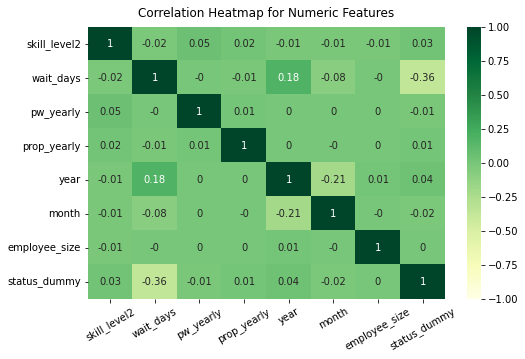

In [ ]:
heatmap_df = perm_df[['status','skill_level2','wait_days','pw_yearly','prop_yearly','year','month','employee_size']]
# convert status to dummy values
heatmap_df = heatmap_df.query('status != "Withdrawn"')
heatmap_df[['status_dummy']] = heatmap_df['status'].map({"Denied":0,"Certified":1,"Certified-Expired":1})
heatmap_df.drop(columns=["status"], inplace= True)
# create heatmap on dataframe correlation
plt.figure(figsize=(8, 5))
hmp = sns.heatmap(round(heatmap_df.corr(),2),vmin=-1, vmax=1, annot=True, cmap='YlGn')
hmp.set_title('Correlation Heatmap for Numeric Features', fontdict={'fontsize':12}, pad=10, loc="center")
plt.xticks(rotation=30)

As the heatmap suggests, variable `wait_days` is obviously negatively correlated with the `status_dummy`, which indicates that we may not include `wait_days` as a regressor to predict application result. However, to make best use of the information embedded in variable `wait_days`,we will run a regression analysis utilizing `wait_days` as a dependent variable to find insights.

In [ ]:
# descriptive statistics
print("Descriptive Statistics for Numeric Features:")
perm_df[['employee_size','wait_days','skill_level2','pw_yearly','prop_yearly']].describe().round()

Descriptive Statistics for Numeric Features:


,employee_size,wait_days,skill_level2,pw_yearly,prop_yearly
count,3.247870e+05,324787.0,324787.0,324787.0,324787.0
mean,6.556200e+04,152.0,3.0,98512.0,120885.0
std,4.046440e+06,152.0,1.0,347321.0,566008.0
min,0.000000e+00,1.0,1.0,13920.0,14400.0
25%,1.650000e+02,90.0,2.0,76794.0,91500.0
50%,3.127000e+03,134.0,2.0,96595.0,115835.0
75%,3.308000e+04,180.0,3.0,116875.0,140000.0
max,2.062661e+09,4947.0,4.0,149679360.0,195006720.0


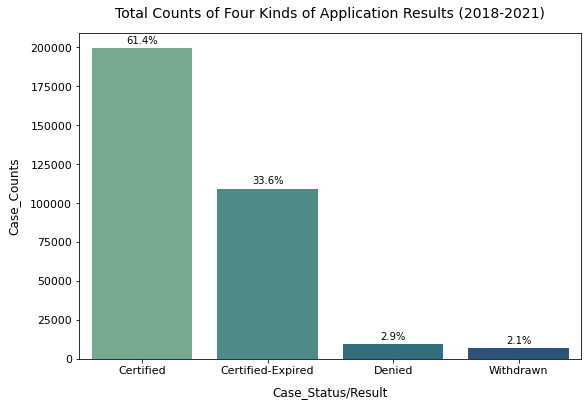

In [ ]:
# Distribution of different application results
status = perm_df.groupby("status").size().reset_index(name='case_counts')
total = status['case_counts'].sum()
status[["percentage %"]] = round(status[['case_counts']] / total,3)*100
# initialize canvas
plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams.update({'font.size': 12})
ax = sns.barplot(x=status['status'], y=status['case_counts'], palette="crest")
patches = ax.patches
# add percentage % on each bar
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height() + 3
   ax.annotate('{:.1f}%'.format(status['percentage %'][i]), (x, y), ha='center',size=10, xytext=(0, 5),textcoords='offset points')
ax.set_ylabel('Case_Counts', fontsize=12)
ax.set_xlabel('Case_Status/Result', fontsize=12)
plt.title('Total Counts of Four Kinds of Application Results (2018-2021)', fontsize= 14, pad=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
plt.show()

Above distribution tells us that our sample is quite imbalanced. Denied cases is merely around 5% of certified ones in size. This is a reminder that we need to do undersampling/upsampling to reduce prediction bias in prediction models. 

In [ ]:
counts = perm_df.groupby(['year', 'status']).agg({'case_id': 'count'})
pcts = counts.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()),1))
pcts_lst = pcts['case_id'].reset_index()['case_id'].to_list()
pcts_lst.insert(0,0.0) # becasue cases in year 2018 ranges from Oct 1st 2017 to 2018 Sep 30th
print(pcts_lst)
pcts_lst = [0.0, 63.5, 56.9, 60.0, 77.1, 91.9, 31.2, 38.3, 34.8, 19.0, 5.0, 3.3, 3.1, 2.8, 1.8, 3.1, 2.0, 1.7, 2.4, 2.1] # rearrange the sequence of percentages

[0.0, 91.9, 5.0, 3.1, 63.5, 31.2, 3.3, 2.0, 56.9, 38.3, 3.1, 1.7, 60.0, 34.8, 2.8, 2.4, 77.1, 19.0, 1.8, 2.1]


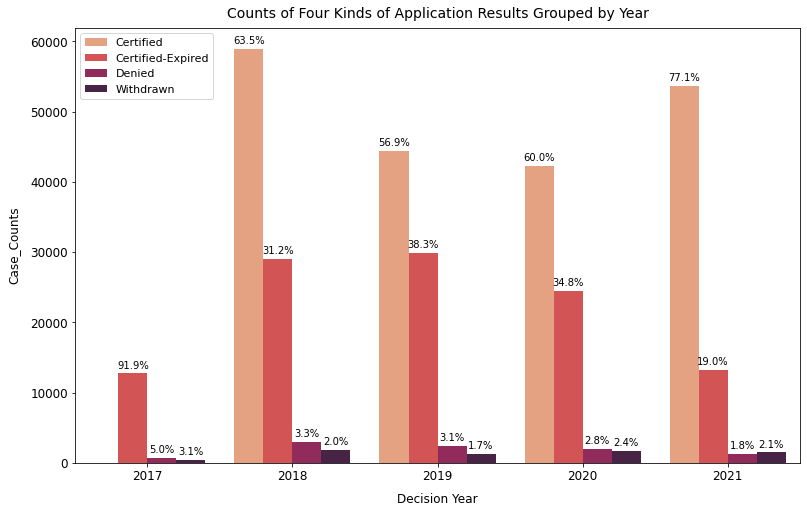

In [ ]:
status_by_year = perm_df.groupby(["year","status"]).count()
status_by_year = status_by_year[['case_id']].rename(columns = {"case_id":"case_counts"}).sort_values("case_counts", ascending =False)
status_by_year = status_by_year.reset_index()

plt.figure(figsize = [13,8]) # set the figure size
plt.rcParams.update({'font.size': 12})
ax = sns.barplot(x="year", y="case_counts", hue="status", data=status_by_year,palette="rocket_r") # hue for the nexted feature,
ax.set_title("Counts of Four Kinds of Application Results Grouped by Year", pad=10, fontdict={"fontsize": 14})
plt.ylabel("Case_Counts", size=12, labelpad=10)
plt.xlabel("Decision Year", size=12, labelpad= 10)
plt.legend(loc='upper left', prop={'size': 11})
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height() + 3
   ax.annotate('{:.1f}%'.format(pcts_lst[i]), (x, y), ha='center',size=10, xytext=(0, 5),textcoords='offset points')
plt.show()

You may be wondering why we don't have certified cases in 2017. the reason behind is that DoL's disclosure year differs from a normal calendar fiscal year (Jan to Dec), the former defines one year's records as those start from last year's Oct 1st and end on Sep 30th of the current year. E.g., 2018 disclosure year's data include records whose decisions are made during 2017 Oct 1st -- 2018 Sep 30. By the time that 2018's data is organized and publicized, all applications in 2018's disclosure whose certified decisions are made before 2018, Mar 31 are noted as certified-expired. That's also why we will combine the certified and certified-expired data together before resampling. Because these two types are essentially both certified cases under the cover.

## 3.1 Company Size and Employers:
Does a company of larger size increase the possibility of getting a certified application? 
In the histogram below, company size is measured by the number of employees of a firm. And it seems like that the `employee_size` associated with certified applications is indeed larger than that of denied cases, implying that larger companies give applicants an advantage in PERM application process compared to smaller ones.

Top Employers that intend to hire international workers and sponsor their perm applications are also visualized.

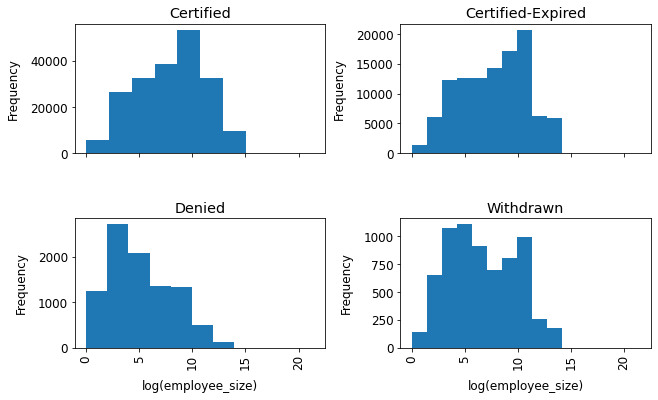

In [ ]:
employee_size = perm_df[['employee_size','status']]
employee_size[['size_log']] = np.log(perm_df[['employee_size']]+1)
axarr = employee_size.hist(column="size_log",figsize = (10,6),by="status", bins=10, sharex=True)
# add x,y labels
for ax in axarr.flatten():
    ax.set_xlabel("log(employee_size)", fontsize=12, labelpad=10)
    ax.set_ylabel("Frequency", fontsize=12, labelpad=10)

In [ ]:
# list the top 15 employers in certified cases
import plotly.express as px
# from here, we will focus on certified applications only, to extract characteristics of successful applications
perm_certified_df = perm_df.query("status == 'Certified' or status == 'Certified-Expired'") # filter out certified cases
popular_employer_df = perm_certified_df.groupby(by = ["employer_name","work_city"]).count().rename(columns = {"case_id":"case_counts"}).reset_index()[['employer_name','case_counts',"work_city"]]
popular_employer_df = popular_employer_df.sort_values("case_counts", ascending= False)
# draw a horizontal barplot
fig = px.bar(popular_employer_df.head(15), x="case_counts", y="employer_name", color="work_city", orientation='h',
             hover_data=["case_counts", "employer_name","work_city"],
             height=450, width = 900,
             title='Top 15 Employers for Certified Applications (2018-2021)')
fig.show()

## 3.2 Location

Below we plotted three barplots showing the number of certified applications grouped by State -> Region -> City. We show top locations in each grouping so viewers are able to sense where might more opportunites and demand exist. Results show that Carlifornia, The Bay Area (excluding San Francisco), New York ranks NO.1 among all popular locations in terms of state, region, city dimension, respectively.

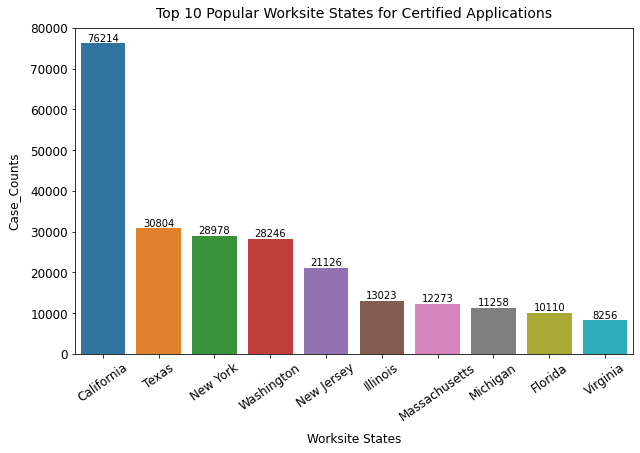

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plt.rcParams.update({'font.size': 12})
#barplot
barplot =sns.countplot(x='work_state_cleaned', data=perm_certified_df, order=perm_certified_df.work_state_cleaned.value_counts().iloc[:10].index)
# formatting
ax.set_title("Top 10 Popular Worksite States for Certified Applications", pad= 10, fontdict={"fontsize": 14})
plt.ylabel("Case_Counts", size=12, labelpad=10)
plt.xlabel("Worksite States", size=12, labelpad= 10)
plt.xticks(rotation=35, fontsize =12)
plt.yticks(fontsize =12)
# add tags
for p in barplot.patches:
             barplot.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height() + 5),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()


In ensuing query, we combine cities: `Mountain View`, `San Jose`, `Santa Clara`, `Sunnyvale`, `Cupertino`, `Menlo Park` as the Bay Area; and `Seattle` and `Redmond` are united as the Seattle Area.

In [ ]:
# combine other top counties/cities except SF in the San Francisco Bay Area
region_data = perm_certified_df['work_city'].value_counts().iloc[:20]
region_df = pd.DataFrame(region_data).reset_index().rename(columns={"index":"work_city","work_city":"counts"})
bay_area_counts = pandasql.sqldf('''SELECT SUM(counts) AS Bay_area_counts FROM region_df WHERE 
work_city = 'Mountain View' OR work_city = 'San Jose' OR work_city = 'Santa Clara' OR work_city = 'Sunnyvale' OR
work_city = 'Cupertino' OR work_City = 'Menlo Park' ''', globals())

# combine Seattle and Redmond as Seattle area
Seattle_Redmond_area_counts = pandasql.sqldf('''SELECT SUM(counts) AS Seattle_Redmond_area_counts FROM region_df WHERE 
work_city = 'Seattle' OR work_city = 'Redmond' ''', globals())

rest_df = pandasql.sqldf('''SELECT * FROM region_df 
WHERE work_city <> 'Seattle' AND work_city <> 'Redmond' AND 
work_city <> 'Mountain View' AND work_city <> 'San Jose' AND work_city <> 'Santa Clara' AND work_city <> 'Sunnyvale' AND
work_city <> 'Cupertino' AND work_City <> 'Menlo Park' ''', globals())
rest_df = rest_df.append({"work_city":"Bay Area","counts":bay_area_counts.iloc[0,0].tolist()}, ignore_index=True)
region_new_df = rest_df.append({"work_city":"Seattle area","counts":Seattle_Redmond_area_counts.iloc[0,0].tolist()}, ignore_index=True)
region_new_df = region_new_df.sort_values(by ="counts", ascending= False).reset_index(drop=True)

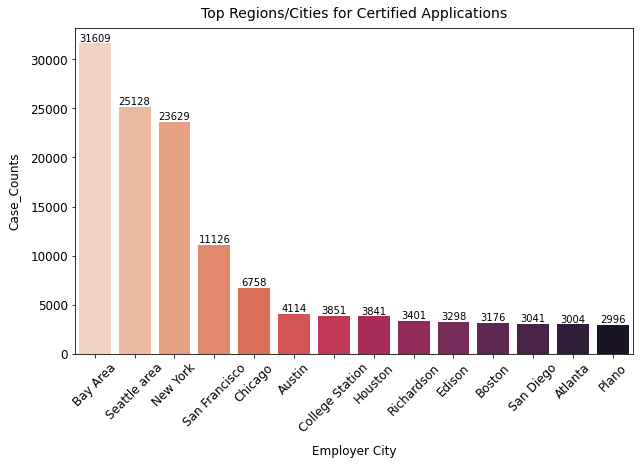

In [ ]:
# plot the employer_cities with top 10 highest certified case_counts
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
plt.rcParams.update({'font.size': 12})
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":20})
sns.light_palette("seagreen", as_cmap=True) 
# fetch the top 10 cities with the most case_counts
bar =sns.barplot(x='work_city', y="counts", data=region_new_df, palette="rocket_r")
# formatting
ax.set_title("Top Regions/Cities for Certified Applications", pad= 10, fontdict={"fontsize": 14})
plt.ylabel("Case_Counts", size=12, labelpad=10)
plt.xlabel("Employer City", size=12, labelpad= 10)
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(fontsize = 12)
# add number on the top of bars
for p in bar.patches:
             bar.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+5),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

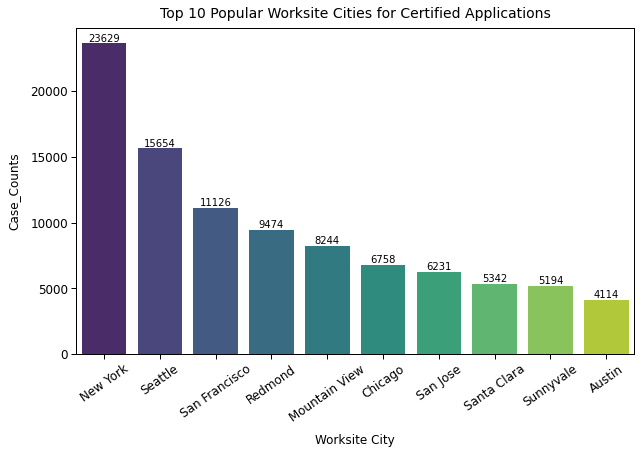

In [ ]:
# set plot size, font base, color
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plt.rcParams.update({'font.size': 12})
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":20})
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
# barplot
barplot =sns.countplot(x='work_city', data=perm_certified_df, order=perm_certified_df.work_city.value_counts().iloc[:10].index,palette="viridis")
# formatting
ax.set_title("Top 10 Popular Worksite Cities for Certified Applications", pad= 10, fontdict={"fontsize": 14})
plt.ylabel("Case_Counts", size=12, labelpad=10)
plt.xlabel("Worksite City", size=12, labelpad= 10)
plt.xticks(rotation=35, fontsize = 12)
plt.yticks(fontsize =12)
# add tags
for p in barplot.patches:
             barplot.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+5),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

## 3.3 Job Title and Salary

In this section, We firstly, produced a word cloud picture constitued of `job_title` of certified applications. Expectedly, we capture that most jobs are engineering-related, such as Software Engineer, Design Developer, Support Enginner, Business Intelligence analyst, Data Scientist, etc. Some other less technology-specific job title examples are Associate Director, Consultant, Product Manager and so on.


In [ ]:
import random
from wordcloud import WordCloud, STOPWORDS
# define a color generator
def cust_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
  h = random.randint(0, 300)
  s = random.randint(0, 100)
  l = random.randint(0, 100)
  return f"hsl({h}, {s}%, {l}%)"

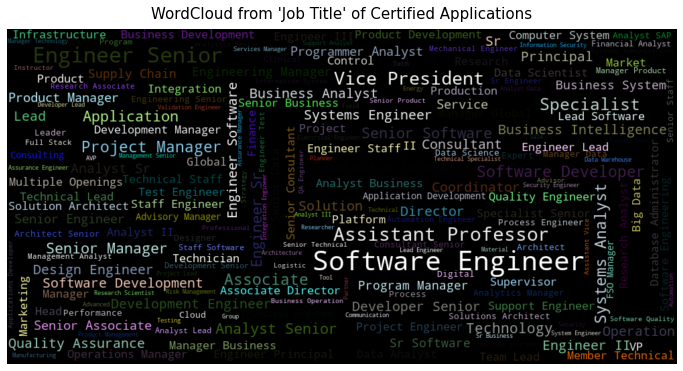

In [ ]:
job_title_df = perm_certified_df.groupby("job_title").count().rename(columns = {"case_id" :"case_counts"}).reset_index()
job_titles = job_title_df['job_title']
job_titles_one_string = ' '.join([job for job in job_titles.values])
# generate a wordcloud
wordcloud = WordCloud(width=1000, height=500, max_font_size=40).generate(job_titles_one_string)
# display the image:
plt.figure(figsize=(12,8))
plt.tight_layout(pad=0)
plt.title("WordCloud from 'Job Title' of Certified Applications", fontsize = 15, pad=10, loc="center")
plt.imshow(wordcloud.recolor(color_func=cust_color_func, random_state=1), interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# select job titles that contain "Data"
data_related_df = perm_certified_df[perm_certified_df['job_title'].str.contains("Data")][['case_id','job_title','occupation_name','work_city',"prop_yearly"]]
data_pie = data_related_df.groupby("job_title").count().sort_values("case_id", ascending = False).rename(columns = {"case_id" : "case_counts"}).reset_index()[['job_title','case_counts']]
# draw pieplot for top 20 Data related jobs, see their composition
fig = px.pie(data_pie.head(20), values='case_counts', names='job_title',
             title='Top 20 Data Related Job Categories among Certified Cases',
             height=500, width = 900,
             color_discrete_sequence=px.colors.sequential.GnBu_r)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Secondly, we draw a pie chart with all job titles that contain the key word "data" to display the composition of the "data industry". Top 3 job titles associated with data processing are Data Scientist, Database Administrator, and Data Engineer.

Thirdly in this part, we verified one of our hypothesis that wage is positively correlated to PERM application success. From the box plot below, it is clearly seen that the certified group has a higher median annual wage than the denied group. This holds true for both proposed annual wage from employers and the prevailing wage of applicants' professions. 

Text(0.5, 1.0, 'Boxplot of Proposed Annual Wage(log)')

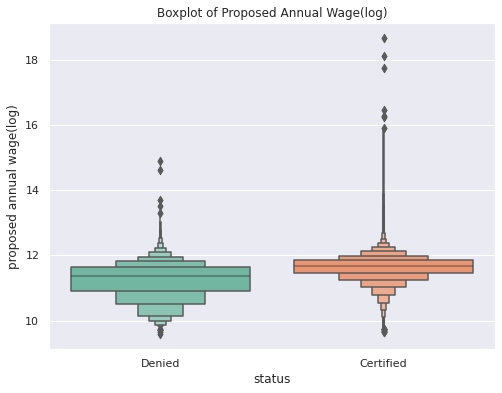

In [ ]:
perm_salary_df = perm_df.query("status == 'Denied' or status == 'Certified'")
perm_salary_df[['prop_yearly_log']] =perm_salary_df[['prop_yearly']].apply(lambda x: np.log(x+1))
perm_salary_df[['pw_yearly_log']] =perm_salary_df[['pw_yearly']].apply(lambda x: np.log(x+1))
sns.set(rc={'figure.figsize':(8,6)})
b1 = sns.boxenplot(x= perm_salary_df.status, y= perm_salary_df.prop_yearly_log, palette = "Set2")
b1.set_xlabel("status",fontsize = 12)
b1.set_ylabel("proposed annual wage(log)", fontsize= 12, labelpad=5)
b1.set_title("Boxplot of Proposed Annual Wage(log)")

Text(0.5, 1.0, 'Boxplot of Prevailing Annual Wage(log)')

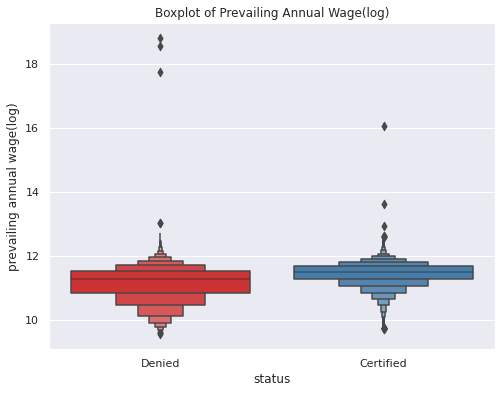

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
b2 = sns.boxenplot(x= perm_salary_df.status, y= perm_salary_df.pw_yearly_log, palette = "Set1")
b2.set_xlabel("status",fontsize = 12)
b2.set_ylabel("prevailing annual wage(log)", fontsize= 12, labelpad=5)
b2.set_title("Boxplot of Prevailing Annual Wage(log)")


If you are curious about what states have the most tempting payment? Feel free to play with the Median Wage Map below. You can also use the filter  (filtering based on PERM application result) at the right top to see result from certain groups. The toolbar at the top left can help you zoom in, out and back to the default zoom setting.

In [ ]:
%%HTML
<div class='tableauPlaceholder' id='viz1637875822533' style='position: relative'>
   <noscript><a href='#'><img alt='Median Wage Map Grouped by State ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;FK&#47;FKJR6R22R&#47;1_rss.png' style='border: none' /></a></noscript>
   <object class='tableauViz'  style='display:none;'>
      <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' />
      <param name='embed_code_version' value='3' />
      <param name='path' value='shared&#47;FKJR6R22R' />
      <param name='toolbar' value='yes' />
      <param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;FK&#47;FKJR6R22R&#47;1.png' />
      <param name='animate_transition' value='yes' />
      <param name='display_static_image' value='yes' />
      <param name='display_spinner' value='yes' />
      <param name='display_overlay' value='yes' />
      <param name='display_count' value='yes' />
      <param name='language' value='en-US' />
      <param name='filter' value='publish=yes' />
   </object>
</div>
<script type='text/javascript'>                    var divElement = document.getElementById('viz1637875822533');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## 3.4 Wage versus Education

This box plot shows the proposed annual wage distribution for different education background. 

Surprisingly, there's no significant difference between people with Bachelor and Master, even Doctorate degree. One possible explanation is that people in PERM application generally have a higher salary range (in order for them to apply), so the the wage difference is narrowed in the first place. 

You may also notice that people with "Other Education" have a higher average salary than others. This is because "other education" includes some other graduate-level degree such as JD (Doctor of Law or Doctor of Jurisprudence) and MD (Doctor of Medicine), which are expected to have a high salary.

Text(0.5, 1.0, 'Boxplot of Proposed Annual Wage(log) among 7 education backgrounds')

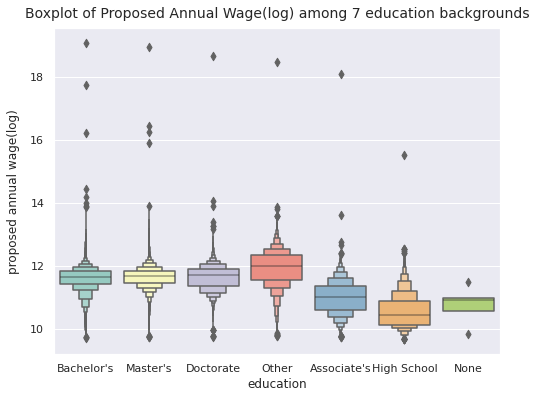

In [ ]:
wage_education_df = perm_certified_df[['education','prop_yearly']]
wage_education_df['prop_yearly_log'] = wage_education_df[['prop_yearly']].apply(lambda x: np.log(x+1))

sns.set(rc={'figure.figsize':(8,6)})
b1 = sns.boxenplot(x= wage_education_df.education, y= wage_education_df.prop_yearly_log, palette = "Set3")
b1.set_xlabel("education",fontsize = 12)
b1.set_ylabel("proposed annual wage(log)", fontsize= 12, labelpad= 10)
b1.set_title("Boxplot of Proposed Annual Wage(log) among 7 education backgrounds", pad =10, fontsize = 14)

## 3.5 Citizenship and Admission

Another intriguing question is "Does an applicant's original citizenship make a difference for one's PERM application?". From the application success rate map follows, we learn that most countries have relatively high success rate. There is no evident discrimination on application's `home_country` with respect to PERM application decision.

In [ ]:
citizenship_df = perm_certified_df.groupby(by = ["curr_visa","home_country"]).count().rename(columns = {"case_id":"case_counts"}).reset_index()[["curr_visa","home_country",'case_counts']]
citizenship_df = citizenship_df.sort_values("case_counts", ascending= False)
# draw a horizontal barplot
fig = px.bar(citizenship_df.head(20), x="case_counts", y="home_country", color="curr_visa", orientation='h',
             height=450, width = 900)
fig.update_layout(
    title='Top 10 Citizenship for Certified Applications (2018-2021)',
    title_x = 0.5,
    width=750,
    height=500,
    font=dict(size=12))
fig.show()

In above bar plot, the output shows us that India, China and Canada are where most of PERM applicants come from. Plus, we also distinguish applicants' current visa status within each `home_country`, which reveals that H1-B vias is the type of visa most applicants hold when they submit their PERM applications.

In [ ]:
# prefer certain countries?
country_diff_df = perm_df.query("status != 'Withdrawn'")
country_diff_df[['status']] = country_diff_df[['status']].apply(lambda x: x.str.replace("Certified-Expired","Certified"))
country_diff1_df = country_diff_df.groupby(by = ["home_country","status"]).count().rename(columns = {"case_id":"case_counts"}).reset_index()[['home_country','case_counts','status']]
country_diff2_df = country_diff1_df.groupby("home_country").sum("case_counts").rename(columns = {"case_counts" :"total_counts"}).reset_index()[['home_country','total_counts']]
country_diff_merged_df = country_diff1_df.merge(country_diff2_df, left_on="home_country",right_on="home_country")
country_diff_merged_df[['ratio']] = round(country_diff_merged_df['case_counts']/ country_diff_merged_df['total_counts'],4)
country_success_rate = country_diff_merged_df[['home_country','ratio']].where(country_diff_merged_df["status"]=="Certified").dropna().rename(columns = {"ratio":"success_rate"})
country_fail_rate = country_diff_merged_df[['home_country','ratio']].where(country_diff_merged_df["status"]=="Denied").dropna().rename(columns = {"ratio":"fail_rate"})
# country_fail_rate.to_csv("country_fail_rate2.csv", index = False)
# country_success_rate.to_csv("country_success_rate2.csv", index = False)
# implementd in Tableau

In [ ]:
%%HTML
<div class='tableauPlaceholder' id='viz1638673401623' style='position: relative'>
   <noscript><a href='#'><img alt='Perm Application Success Rate Basing on Citizenship ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Su&#47;SuccessRate_16375551836550&#47;PermApplicationSuccessRateBasingonCitizenship&#47;1_rss.png' style='border: none' /></a></noscript>
   <object class='tableauViz'  style='display:none;'>
      <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' />
      <param name='embed_code_version' value='3' />
      <param name='site_root' value='' />
      <param name='name' value='SuccessRate_16375551836550&#47;PermApplicationSuccessRateBasingonCitizenship' />
      <param name='tabs' value='no' />
      <param name='toolbar' value='yes' />
      <param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Su&#47;SuccessRate_16375551836550&#47;PermApplicationSuccessRateBasingonCitizenship&#47;1.png' />
      <param name='animate_transition' value='yes' />
      <param name='display_static_image' value='yes' />
      <param name='display_spinner' value='yes' />
      <param name='display_overlay' value='yes' />
      <param name='display_count' value='yes' />
      <param name='language' value='en-US' />
      <param name='filter' value='publish=yes' />
   </object>
</div>
<script type='text/javascript'>                    var divElement = document.getElementById('viz1638673401623');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

One abnormal feature that stood out immediately is the fact that there are a number of PERM applicants claiming to possess US citizenship.

This does not really make intuitive sense as PERM applicants by definition do not possess Green Cards and cannot be a US citizen to start with. Our guess is that these people may be, say, undocumented immigrants, do not possess any passports etc., or simply errors.

Data shows that there are only 326 data points prone to this issue out of some 300,000 (~0.1%). Further eye-balling doesn't show any major issues with data quality as well, apart from the fact that they put down "US" as their citizenship. As such, we decide to keep the data points.

In [ ]:
perm_df[perm_df['home_country'] == 'United States Of America'].describe()

,employee_size,wait_days,skill_level2,pw_yearly,prop_yearly,year,month,received_year,received_month,industry_code_cleaned
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,13755.103933,228.255618,2.233146,82786.988764,101453.457444,2019.000000,6.755618,2018.393258,6.539326,503.140449
std,61015.083200,371.012227,1.055701,35929.652542,51600.998542,1.203282,3.163942,1.638398,3.421741,107.369272
min,1.000000,1.000000,1.000000,17035.000000,17035.000000,2017.000000,1.000000,2009.000000,1.000000,111.000000
25%,34.750000,100.750000,1.000000,56404.750000,66170.250000,2018.000000,4.000000,2018.000000,4.000000,454.000000
50%,277.500000,145.000000,2.000000,79498.000000,96797.500000,2019.000000,6.000000,2018.000000,7.000000,541.000000
75%,4000.000000,221.000000,3.000000,105700.500000,127371.875000,2020.000000,9.000000,2020.000000,9.000000,541.000000
max,695025.000000,3346.000000,4.000000,208000.000000,350000.000000,2021.000000,12.000000,2021.000000,12.000000,814.000000


In [ ]:
perm_df[perm_df['home_country'] == 'United States Of America'].head(20)

,case_id,status,received_date,decision_date,employer_name,employer_city,employer_country,employee_size,soc_code,ownership,soc_title,skill_level,work_city,work_postcode,job_title,special_skills,home_country,curr_visa,education,major,wait_days,skill_level2,pw_yearly,prop_yearly,year,month,received_year,received_month,occupation_name,industry_code_cleaned,industry_name,work_state_cleaned
2300,A-19343-92753,Denied,2019-12-13,2020-11-03,Wipro Limited,East Brunswick,United States Of America,13700,15-1132,N,"Software Developers, Applications",Level II,East Brunswick,08816,Lead Software Engineer - Mainframe (Multiple O...,Must have full life cycleend to end experience...,United States Of America,H-1B,Master's,Computer Applications,326,2,96366.0,108183.0,2020,11,2019,12,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",New Jersey
3003,A-20083-33893,Denied,2020-05-19,2020-11-12,Rle International,Dearborn,United States Of America,90,17-2141,N,Mechanical Engineers,Level II,Dearborn,48120,Core Mechanical Project Engineer,Education Bachelor Mechanical Engineering;br ...,United States Of America,H-1B,Master's,Mechanical Engineering,177,2,81162.0,100000.0,2020,11,2020,5,Mechanical Engineers,541,"Professional, Scientific, and Technical Services",Michigan
3644,A-20114-46710,Certified-Expired,2020-05-18,2020-11-20,"The Alliance, Inc.",Minneapolis,United States Of America,114,17-3011,N,Architectural and Civil Drafters,Level I,Minneapolis,55403,Architectural Intern II,Minimum requirements for the offered position ...,United States Of America,H-1B,Master's,Architecture,186,1,40352.0,52139.0,2020,11,2020,5,Architectural and Civil Drafters,541,"Professional, Scientific, and Technical Services",Minnesota
3862,A-19344-93070,Denied,2019-12-13,2020-11-25,Wipro Limited,East Brunswick,United States Of America,13700,15-1132,N,"Software Developers, Applications",Level II,East Brunswick,08816,Lead Software Engineer - Java-J2EE (Multiple O...,Must have full life cycleend to end experience...,United States Of America,H-1B,Master's,Computer Applications,348,2,96366.0,108183.0,2020,11,2019,12,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",New Jersey
6261,A-20174-68126,Certified-Expired,2020-06-23,2021-01-08,Milclean Usa Llc,Deerfield Beach,United States Of America,25,13-2051,N,Financial Analyst,Level II,Deerfield Beach,33442,Financial Analyst,"Experience in budget planning and analysis, ca...",United States Of America,F-1,Master's,Business Administration,199,2,65000.0,65000.0,2021,1,2020,6,Financial and Investment Analysts,541,"Professional, Scientific, and Technical Services",Florida
7978,A-20164-65005,Certified-Expired,2020-07-07,2021-02-09,"Optimal Rehab Abilities, Inc.",Fresno,United States Of America,100,29-1127,N,SpeechLanguage Pathologists,Level II,Tracy,95376,Speech-Language Pathologist (Rehab Director),Requires a Masters or foreign equivalent in Sp...,United States Of America,H-1B,Master's,Speechlanguage Pathology,217,2,77854.0,94080.0,2021,2,2020,7,Speech-Language Pathologists,541,"Professional, Scientific, and Technical Services",California
10274,A-20216-84119,Certified-Expired,2020-08-03,2021-03-15,"Apogee Medical Group, Waukesha, Sc",Scottsdale,United States Of America,60,29-1063,N,Hospitalist Physician,Level I,Waukesha,53188,Hospitalist Physician,Must have or be eligible for a Wisconsin medic...,United States Of America,H-1B,Other,Medicine,224,1,180544.0,320000.0,2021,3,2020,8,Hospitalist Physician,541,"Professional, Scientific, and Technical Services",Wisconsin
12726,A-20099-40668,Certified,2020-04-10,2021-04-09,Superior Bread Company,Livonia,United States Of America,18,51-3011,N,Baker,Level I,Livonia,48150,Baker,None,United States Of America,F-1,Bachelor's,Psychology,364,1,21362.0,21500.0,2021,4,2020,4,Bakers,541,"Professional, Scientific, and Technical Services",Michigan
14292,A-20259-99778,Certified,2020-09-22,2021-04-21,"International Montessori School, Inc.",D

# Section 4: Prediction Models

## 4.1 Solve Imbalance through Over/UnderSampler

As we can see from previous sections, the percentage of denied cases is in the low single-digits. To address the imbalance between the certified and denied cases, we make use of an oversampler / undersampler. We reproduce our dataframe `perm_df` again below for easy reading.

Also note that "Certified" and "Certified-Expired" cases are essentially all approved cases. The only difference is that "Certified-Expired" cases have been approved by the US Government for more than 6 months when the data is published (and therefore "expired"). An expired approval nonetheless does not affect the fact that the applicant has been granted a PERM approval. As such, we would combine both and put them into the bucket of "Certified" cases altogether.

In [ ]:
perm_df = pd.read_csv("/content/perm_full4.csv")

In [ ]:
perm_model_df = perm_df[perm_df['status'] != 'Withdrawn']
perm_model_df['status'] = perm_model_df['status'].apply(lambda x: "Certified" if x == "Certified-Expired" else x)

Over 2017-2021, there is a total of 308,588 approved PERM applications and only 9,374 denied applications, with year-by-year numbers printed below. This calls for some form of re-sampling.

<b>There also seems to be a declining trend of denial rate from > 5% in 2017 to < 2% in 2021. This is an interesting observation that we will come back to after we have carried out our Logistic Regression.</b>

In [ ]:
print("Total no. of approved PERM applications over 2018 - 2021: ", len(perm_model_df[perm_model_df['status'] == 'Certified']))
print("Total no. of denied PERM applications over 2018 - 2021: ", len(perm_model_df[perm_model_df['status'] == 'Denied']))
print("Split by year:")
perm_model_df.groupby(['year', 'status']).count()[['case_id']]

Total no. of approved PERM applications over 2018 - 2021:  308588
Total no. of denied PERM applications over 2018 - 2021:  9374
Split by year:


case_id
year status            
2017 Certified    12731
     Denied         693
2018 Certified    87962
     Denied        3024
2019 Certified    74312
     Denied        2444
2020 Certified    66743
     Denied        1982
2021 Certified    66840
     Denied        1231

In [ ]:
features = perm_model_df.drop(columns="status")
labels = perm_model_df[['status']]
print("number of observations after dropping withdrawn and expired: ",len(features.index)) 

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

ros = RandomOverSampler(sampling_strategy=0.2, random_state=6) # oversample minority group until N(minority) / N(majority) to be 0.2
features_res, labels_res = ros.fit_resample(features,labels)
print("number of observations after oversampling denied cases:", len(features_res.index))

rus = RandomUnderSampler(sampling_strategy=0.85, random_state=545) #undersample majority group until N(minority) / N(majority) is 0.85
features_res, labels_res = rus.fit_resample(features_res, labels_res)
print("number of observations after undersampling certified cases:", len(features_res.index))

number of observations after dropping withdrawn and expired:  317962
number of observations after oversampling denied cases: 370305
number of observations after undersampling certified cases: 134325


## 4.2 Predicting Acceptance / Denial

### 4.2.1 Data Treatment

Now we get balanced samples. To facilitate our predictions, we also need to carry out-
- <b>One-hot encoding</b> for columns which contain categorical data
- <b>Re-scaling</b> for some of our columns with continuous data (logging of company size and income levels in our case)
- <b>Standard-scaling, followed by Principle Component Analysis (PCA) to tackle multi-collinearity</b> as necessary when feeding into our prediction models

We start off by encoding the application result (denial = 0 ; approval = 1)

In [ ]:
labels_res[['status_code']] = labels_res['status'].map({"Denied":0,"Certified":1})
labels_encoded = labels_res[['status_code']]
labels_encoded

,status_code
0,1
1,1
2,1
3,1
4,1
...,...
134320,0
134321,0
134322,0
134323,0


We take a step back and review the features we have on hand. In fact, a lot of the variables we have on hand are not particularly "regressable" or are somewhat overlapping in nature, or would give rise to "faulty" statistical results due to overfitting / reverse casuality etc. For instance:
- Instead of feeding `employer_city` into our prediction model, we might be better off feeding `employer_state` into it which would allow us to generalize on a higher level
- Some features have standardized codes made available (e.g. `industry_name` represented by `industry_code_cleaned`) so it would suffice simply by one-hot encoding the industry code
- `Wait_days` is better off left out of the model, despite it likely being highly correlated with application result. (e.g. The more convincing an application is, the shorter the wait likely is.)
 - <b>Note:</b> We will separately set up a prediction model for wait days in 4.3 to see whether the variables underlying `wait_days` significantly differ from application results

<p>As such, we would need to further narrow down our features.</p>



In [ ]:
features_res.head(5)

,case_id,received_date,decision_date,employer_name,employer_city,employer_country,employee_size,soc_code,ownership,soc_title,skill_level,work_city,work_postcode,job_title,special_skills,home_country,curr_visa,education,major,wait_days,skill_level2,pw_yearly,prop_yearly,year,month,received_year,received_month,occupation_name,industry_code_cleaned,industry_name,work_state_cleaned
0,A-19347-95198,2020-01-13,2020-12-04,Vantage Ic,Holtsville,United States Of America,28,43-4051,N,Customer Service Representatives,Level IV,Deerfield Beach,33442,Customer Service Representatives,"Fluent in French read, spoken and written",France,E-2,Associate's,Accounting,326,4,40685.0,41000.0,2020,12,2020,1,Customer Service Representatives,541,"Professional, Scientific, and Technical Services",Florida
1,A-18267-21345,2018-10-03,2019-01-08,Cognizant Technology Solutions Us Corporation,College Station,United States Of America,45000,15-1132,N,"Software Developers, Applications",Level IV,College Station,77845,Computer Systems Analyst B,Undisclosed,India,H-1B,Bachelor's,Engineering (Computer),97,4,93475.0,93475.0,2019,1,2018,10,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",Texas
2,A-19268-62934,2019-09-26,2019-12-02,"Jri America, Inc.",New York,United States Of America,318,15-1199,N,"Computer Occupations, All Other",Level IV,New York,10172,Enterprise Resource Planning Specialist (AVP),Requirementsbr Bachelors degree in Commerce or...,India,H-1B,Bachelor's,Commerce Threeyear Bachelors Degree,67,4,123552.0,123600.0,2019,12,2019,9,"Computer Occupations, All Other",511,Publishing Industries (except Internet),New York
3,A-18172-89281,2018-11-09,2019-03-14,Kforce Inc.,Tampa,United States Of America,13700,15-1132,N,"Software Developers, Applications",Level II,Tampa,33605,Lead Analyst,Undisclosed,India,H-1B,Bachelor's,Information Technology,125,2,73112.0,101760.0,2019,3,2018,11,"Software Developers, Applications",611,Educational Services,Florida
4,A-20111-44908,2020-04-20,2021-04-14,"Capgemini America, Inc.",Chicago,United States Of America,14000,15-1132,N,"Software Developers, Applications",Level III,Chicago,60606,Manager,Must have experience with each of the followin...,India,H-1B,Master's,Computer Science,359,3,97781.0,129000.0,2021,4,2020,4,"Software Developers, Applications",541,"Professional, Scientific, and Technical Services",Illinois


We then re-scale / one-hot encode suitable columns in our features (<b>features_res</b> reproduced below for easy reference).

We have selected to treat year and month of application, industry, location (by state), current visa status, ownership, and skill level.

In [ ]:
features_to_treat = features_res[['ownership','skill_level2',"curr_visa","education","received_year","received_month","work_state_cleaned","industry_name"]]
features_to_treat["log_wage_ratio"] = features_res["prop_yearly"].map(lambda x: np.log(x)) - features_res["pw_yearly"].map(lambda x: np.log(x))
features_to_treat["log_employee_size"] = features_res["employee_size"].map(lambda x: np.log(1 + x))

In [ ]:
# quite a lot work for one hot encoding becasue many features are categorical 
features_to_treat[['ownership']] = features_to_treat['ownership'].map({"Y":1,"N":0})
features_encoded = pd.get_dummies(features_to_treat, columns = ["curr_visa","work_state_cleaned","industry_name", "education", "received_year", "received_month"])

In [ ]:
len(features_encoded.columns)

241

In [ ]:
features_encoded

,ownership,skill_level2,log_wage_ratio,log_employee_size,curr_visa_A-3,curr_visa_A1/A2,curr_visa_B-1,curr_visa_B-2,curr_visa_C-1,curr_visa_C-3,curr_visa_CW-1,curr_visa_D-1,curr_visa_E-1,curr_visa_E-2,curr_visa_E-3,curr_visa_EWI,curr_visa_F-1,curr_visa_F-2,curr_visa_G-1,curr_visa_G-4,curr_visa_G-5,curr_visa_H-1A,curr_visa_H-1B,curr_visa_H-1B1,curr_visa_H-2A,curr_visa_H-2B,curr_visa_H-3,curr_visa_H-4,curr_visa_I,curr_visa_J-1,curr_visa_J-2,curr_visa_L-1,curr_visa_L-2,curr_visa_M-1,curr_visa_N,curr_visa_Not in USA,curr_visa_O-1,curr_visa_O-2,curr_visa_O-3,curr_visa_P-1,...,industry_name_Warehousing and Storage,industry_name_Waste Management and Remediation Services,industry_name_Water Transportation,industry_name_Wholesale Electronic Markets and Agents and Brokers,industry_name_Wood Product Manufacturing,education_Associate's,education_Bachelor's,education_Doctorate,education_High School,education_Master's,education_None,education_Other,received_year_2006,received_year_2007,received_year_2008,received_year_2009,received_year_2010,received_year_2011,received_year_2012,received_year_2013,received_year_2014,received_year_2015,received_year_2016,received_year_2017,received_year_2018,received_year_2019,received_year_2020,received_year_2021,received_month_1,received_month_2,received_month_3,received_month_4,received_month_5,received_month_6,received_month_7,received_month_8,received_month_9,received_month_10,received_month_11,received_month_12
0,0,4,0.007713,3.367296,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,4,0.000000,10.714440,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,4,0.000388,5.765191,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,2,0.330625,9.525224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,3,0.277082,9.546884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134320,0,1,0.000000,3.891820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
134321,0,1,0.384550,6.666957,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
134322,0,1,0.151676,3.258097,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
134323,0,2,0.401338,3.401197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split # split the dataset into test and training
x_train, x_test, y_train, y_test = train_test_split(features_encoded, labels_encoded, test_size= 0.2, random_state = 7)

In [ ]:
# reset index after splitting train and test set
x_train.reset_index(inplace= True, drop= True)
y_train.reset_index(inplace= True, drop= True)
x_test.reset_index(inplace= True, drop= True)
y_test.reset_index(inplace= True, drop= True)

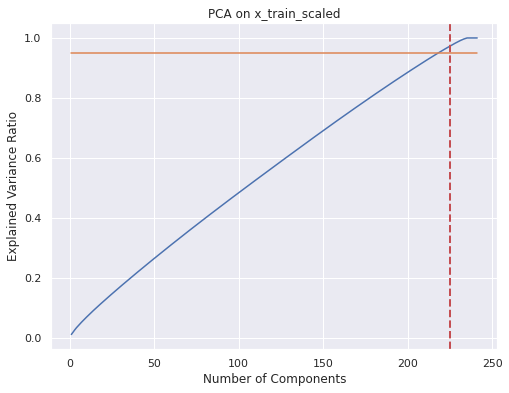

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.transform(x_test)
pca = PCA(n_components = x_train_scaled.shape[1])
pca.fit_transform(x_train_scaled)
# plot the explain variance ratio
n = x_train_scaled.shape[1]
plt.plot(np.arange(1,n+1), np.cumsum(pca.explained_variance_ratio_)) # variance ration against the # of components
plt.plot(np.arange(1,n+1), [0.95]*n) # print to horizontal line to help decide the # of components to use
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA on x_train_scaled")
plt.axvline(linewidth=2, color='r', linestyle = '--', x=225, ymin=0, ymax=1)
plt.show()

Plotting the explained variance ratio against the number of components gives us the a more appropriate number of componets to keep, 225 features. 

<b>While we are aware that 225 features is still a relatively large number, we will still keep this attempt as we believe we have a number of highly collinear features (e.g. with one-hot-encoding, some features may be very negatively correlated with each other, as a person can only be in one industry / one state)</b>.

We will observe whether applying PCA helps us achieve a higher explained variance.

In [ ]:
# build and fit pca with components 
pca2 = PCA(n_components = 225)
x_train_pca = pca2.fit_transform(x_train_scaled)
x_test_pca = pca2.transform(x_test_scaled)

### 4.2.2 Logistic Regression

Given that we are interested in the result of a binary classifier (i.e. certified / denied of PERM), we start off with making use of a logistic regression set-up to see whether there is any insightful findings.

We start off with running a logistic regression on <b>non-standard-scaled and non-PCA treated</b> data.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_lr = LogisticRegression(max_iter=10000)
clf_lr.fit(x_train, np.ravel(y_train))
prediction = clf_lr.predict(x_test)

lr_accuracy = accuracy_score(prediction, y_test)
print("Accuracy of running LR is %.4f" %lr_accuracy)

Accuracy of running LR is 0.7441


We want to find ways to increase the accuracy score. We may for instance, make use of the standard-scaled data in previous parts given the heterogeneity (in terms of variance of our input columns and how they account for the variance in our output columns) in our data.

In [ ]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.transform(x_test)

We re-run our logistic regression model with the standard-scaled data. We can see our accuracy score is essentially the same.

(Note: Going beyond the 4-floating points would give us slight difference - we have expanded it and seen the number is not exactly the same.)

In [ ]:
clf_lr = LogisticRegression(max_iter=10000)
clf_lr.fit(x_train_scaled, np.ravel(y_train))
prediction = clf_lr.predict(x_test_scaled)

lr_accuracy = accuracy_score(prediction, y_test)
print("Accuracy of running LR on standard-scaled data is %.4f" %lr_accuracy)

Accuracy of running LR on standard-scaled data is 0.7441


We'll now proceed to do PCA to see whether it gives us more accuracy. As we can see below, pca-treated data has a very similar accuracy compared to non-pca treated data.

Overall speaking, our logistic regression model is somewhat mediocre and by no means impressive compared to the random forest model in later parts.

In [ ]:
clf_lr_pca = LogisticRegression(max_iter=10000)
clf_lr_pca.fit(x_train_pca, np.ravel(y_train))
prediction = clf_lr_pca.predict(x_test_pca)
lr_pca_accuracy = accuracy_score(prediction, y_test)
print("Accuracy of running LR on standard-scaled AND pca-treated data is %.4f" %lr_pca_accuracy)

Accuracy of running LR on standard-scaled AND pca-treated data is 0.7466


###4.2.3 Interpreting Regression Coefficients

We'll briefly look at the coefficients from our standard-szcaler-treated model to see what are the most important determinants of the success of a PERM application. THe PCA-treated model is not entirely useful as the coefficients have lost its intuitiveness.


<b> We start by examining some of the more intuitive coefficients: </b>
1. <b>log_employee_size</b>: The larger a company is, the more likely the applicant's petition will be approved.
2. <b>log_wage_ratio</b>: The higher the applicant's wage is <b>relative to the industry's prevailing wage</b>, the more likely his/her petition will be approved.
3. <b>education_High School, edu_None, edu_Associate's, edu_Master's</b>: The more educated the applicant is, the more likely his/her petition will be approved.

<b> Some of the more interesting results are: </b>
1. <b>Year of application</b>: At first glance, it appears earlier years of application have a disproportionately lower chance of success. One might infer that the US immigration process have grown to become more leinent over years. This echoes with our observation when we are setting up our over/undersampler.

 HOWEVER, we must not forget that our data is "truncated", and any application results that is approved before September 30, 2017 are not featured in our data. Naturally, only those applications filed before 2017 with a lower chance of success (and probably with a longer wait) are featured in our data.

2. <b>State</b>: A number of states appear to yield particularly low success rates, with <b>Utah, Arkansas, and New Jersey</b> leading (or maybe we should say "tailing") the pack.

3. <b>Industry</b>: Some industries have a particularly high / low approval rates. Industries with high approval rates-
 - Transit and Ground Passenger Transportation
 - Nonstore Retailers
 - Justice, Public Order, and Safety Activities
 - Pipeline Transportation

 Industries with low approval rates
 - Food Manufacturing
 - Social Assistance

In [ ]:
lr_results = pd.DataFrame({'features': x_test.columns, 'coefficients': clf_lr.coef_[0] })
lr_results = lr_results.sort_values(by = 'coefficients', key=pd.Series.abs, ascending = False)
lr_results.head(50)

,features,coefficients
3,log_employee_size,0.748293
220,received_year_2013,-0.704127
219,received_year_2012,-0.620764
223,received_year_2016,-0.518001
228,received_year_2021,0.434282
222,received_year_2015,-0.343368
227,received_year_2020,0.337481
218,received_year_2011,-0.327674
221,received_year_2014,-0.309235
2,log_wage_ratio,0.193766


###4.2.4 Individual States and Industries

Some generalizable takeaways from examining individual states and industries:
- There appears to be a lot of arbitrariness involved in the approval process.
 - Some applications with extremely low proposed salaries were approved (e.g. <b>Arkansas - Peco Foods</b>, whereas a lot of decently high ones were denied (e.g. <b>New Jersey - Wipro Limited</b>).
 - Applications with extremely similar characteristics (similar, salaries, same home country, same employer, and even same visa status) could yield different results.
- One might expect applicants from industries with a social service element (e.g. teaching, counselling) could be approved easily, but examining data from Utah and Social Assistance Industry appeared to suggest otherwise.
- Regarding data quality, we observe that there are a number of applications with wrong industry codes. As a result, we have more noise arising from applicants in the tech industry being wrongly pigeon-holed into other sectors.

#### 4.2.4.1 State

Recall there are a number of states with interesting high / low one-hot state coefficients. We will quickly take a look at each of them in hope of discovering some useful findings.

#####Arkansas

Most of the denied applications in Arkansas come from Peco Foods, Inc, a poultry foods provider.

In [ ]:
perm_ak_df = perm_df[perm_df['work_state_cleaned'] == 'Arkansas'].groupby(['employer_name', 'status']).count()[['case_id']].reset_index()
perm_ak_df[perm_ak_df['status'] == 'Denied'].sort_values(by = 'case_id', ascending = False).head(10)

,employer_name,status,case_id
177,"Peco Foods, Inc",Denied,117
124,Kitestring Consulting Inc,Denied,14
263,Wayne Farms Llc,Denied,12
191,Protech Solutions Inc,Denied,2
183,"Pinnacle Media, Llc",Denied,2
17,Arkansas Department Of Finance And Administration,Denied,2
179,"Pediatrics Plus Therapy Services, Inc.",Denied,1
264,Welspun Pipes,Denied,1
253,Urbix Resources Llc,Denied,1
249,University Of Arkansas For Medical Sciences,Denied,1


<b>The proposed wages are in fact very low even to the common eye, which probably explains the ~50% denial rate of PERM applications. That said, it is still interesting why the remaining 50% was approved, which appeared unanswered from the data.</b>

More interestingly, as we dive deeper, we can also see the followings:
- Most applicants for Peco Foods, Inc. were originally from Vietnam. 
- There is in fact no noticeable differences in the proposed salary of approved and denial applications.
- What differed significantly across certified and denied applications, rather, was whether the applicant was based in USA. Taking all the Vietnamese applicants as an example, basing in USA would yield a success rate of `24 / 33 = 73%` whereas basing outside of USA only yields `69 / 167 = 41%`. This is in line with our generalized observations that applicants based outside USA would have a lower approval rate.

In [ ]:
perm_df[perm_df['employer_name'] == 'Peco Foods, Inc'].groupby(['status', 'home_country']).count()[['case_id']]

case_id
status            home_country         
Certified         South Korea         4
                  Vietnam            23
Certified-Expired China               3
                  South Korea         3
                  Vietnam            71
Denied            Brazil              1
                  China               8
                  South Africa        1
                  Vietnam           107
Withdrawn         Vietnam            10

In [ ]:
perm_df[perm_df['employer_name'] == 'Peco Foods, Inc'].groupby(['status', 'home_country', 'curr_visa']).agg(count=('case_id', 'size')\
      ,avg_proposed_salary=('prop_yearly', 'mean'), avg_prevailing_wage=('pw_yearly', 'mean'))

count  ...  avg_prevailing_wage
status            home_country curr_visa          ...                     
Certified         South Korea  Not in USA      4  ...         20169.600000
                  Vietnam      F-1             4  ...         20193.600000
                               L-1             1  ...         20217.600000
                               Not in USA     18  ...         20217.600000
Certified-Expired China        Not in USA      3  ...         19660.800000
                  South Korea  F-1             2  ...         20121.600000
                               Not in USA      1  ...         20121.600000
                  Vietnam      B-2             1  ...         19641.600000
                               F-1            18  ...         19844.266667
                               F-2             1  ...         19737.600000
                               Not in USA     51  ...         19874.258824
Denied            Brazil       F-2             1  ...         19641.600000
                  China        Not in USA      8  ...         19651.200000
                  South Africa F-1             1  ...         19641.600000
                  Vietnam      F-1             7  ...         19970.742857
                               J-1             2  ...         20217.600000
                               Not in USA     98  ...         19817.926531
Withdrawn         Vietnam      L-1             1  ...         20217.600000
                               Not in USA      9  ...         20217.600000

[19 rows x 3 columns]

#####Utah

Most of the denials in the state of Utah came from the Davis School District ("DSD").

- All 39 applications filed by DSD over 2018-2021 were denied. It was not directly obvious from the data why they were all denied, particularly considering all the job titles correspond to teaching positions.
- The low proposed wage averaging $40,000 annually could be a reason, though as we have seen from Arkansas, workers earning much less had been able to obtain Green Card.
- We tried to look for discrepancies in terms of previous citizenship. While the majority of denied applicants came from China, we also observe a significant number of them coming from France for which denials based on citizenship would be less likely.

In short, data from Utah seemed to be somewhat biased by DSD alone. Wages could be one of the reasons why applications were denied though observations from other state somewhat weaken this proposition.



In [ ]:
perm_ut_df = perm_df[perm_df['work_state_cleaned'] == 'Utah'].groupby(['employer_name', 'status']).count()[['case_id']].reset_index()
perm_ut_df[perm_ut_df['status'] == 'Denied'].sort_values(by = 'case_id', ascending = False)

,employer_name,status,case_id
141,Davis School District,Denied,39
3,Accelerated Engineering,Denied,5
568,Utah State University,Denied,4
528,Telcara Llc,Denied,4
592,"Vivint, Inc.",Denied,3
...,...,...,...
295,Jn Ward & Associates Dba Ward Engineering Group,Denied,1
345,Mountainstar Cardiology At St. Mark'S Llc,Denied,1
346,Mountainstar Cardiology At St. Marks Llc,Denied,1
348,Moxie Pest Control Utah Llc,Denied,1


In [ ]:
perm_df[perm_df['employer_name'] == 'Davis School District'].groupby(['status', 'home_country', 'job_title']).agg(count=('case_id', 'size')\
      ,avg_proposed_salary=('prop_yearly', 'mean'), avg_prevailing_wage=('pw_yearly', 'mean'))

count  ...  avg_prevailing_wage
status home_country job_title                                           ...                     
Denied China        CHINESE IMMERSION TEACHER                        6  ...              40684.0
                    ELEMENTARY CHINESE IMMERSION TEACHER             5  ...              39999.4
                    ELEMENTARY CHINESE TEACHER                       3  ...              39543.0
                    HIGH SCHOOL CHINESE IMMERSION TEACHER            2  ...              39543.0
                    MIDDLE SCHOOL CHINESE TEACHER                    1  ...              39543.0
       France       ELEMENTARY FRENCH IMMERSION TEACHER              6  ...              40684.0
                    ELEMENTARY FRENCH TEACHER                        4  ...              39543.0
       Guatemala    JUNIOR HIGH SPANISH IMMERSION TEACHER            1  ...              40684.0
       Mexico       ELEMENTARY SCHOOL SPANISH IMMERSION TEACHER      2  ...              39543.0
                    ELEMENTARY SPANISH IMMERSION TEACHER             2  ...              40684.0
                    ELEMENTARY SPANISH TEACHER                       2  ...              39543.0
       Spain        ELEMENTARY SPANISH IMMERSION TEACHER             1  ...              40684.0
                    ELEMENTARY SPANISH TEACHER                       1  ...              39543.0
                    HIGH SCHOOL SPANISH IMMERSION TEACHER            2  ...              39543.0
                    MIDDLE SCHOOL SPANISH TEACHER                    1  ...              39543.0

[15 rows x 3 columns]

#####New Jersey

For New Jersey, we observe yet again another outlier employer, Wipro Limited, a Indian-based NYSE-listed tech company worth $45 billion
- While one would expect filing applications with such a big conglomerate in the tech industry would be more successful, approval rates were only ~60%.
- It is entirely ambiguous why some applications were approved while some were denied. The proposed salary for denied applicants were in fact <b>in par with</b> those being approved, as well as the level of wages in east coast states.
- A large number of applicants are also currently on H-1B visa. Given that H-1B applicants also had to go through one round of screening to ensure they do not adversely affect the employment prospects of local US workers, this poses a bigger question mark.

In [ ]:
perm_nj_df = perm_df[perm_df['work_state_cleaned'] == 'New Jersey'].groupby(['employer_name', 'status']).count()[['case_id']].reset_index()
perm_nj_df[perm_nj_df['status'] == 'Denied'].sort_values(by = 'case_id', ascending = False)

,employer_name,status,case_id
4606,Wipro Limited,Denied,409
951,Comtek Global Inc,Denied,20
306,"Apex Technology Systems, Inc",Denied,15
1606,"Fusion Plus Solutions, Inc",Denied,12
3967,"Strategic Resources International, Inc",Denied,10
...,...,...,...
1943,Iflowsoft Solutions Inc,Denied,1
1926,"I5Tech, Inc",Denied,1
1912,"Humetis Technologies,Inc.",Denied,1
1891,"Hp Enterprise Services, Llc",Denied,1


In [ ]:
perm_df[perm_df['employer_name'] == 'Wipro Limited'].groupby(['status', 'home_country', 'curr_visa']).agg(count=('case_id', 'size')\
      ,avg_proposed_salary=('prop_yearly', 'mean'), avg_prevailing_wage=('pw_yearly', 'mean'))

count  ...  avg_prevailing_wage
status            home_country             curr_visa          ...                     
Certified         India                    H-1B          519  ...         99454.183044
                                           Not in USA      7  ...         92809.428571
Certified-Expired India                    H-1B          146  ...         99751.356164
                                           Not in USA      5  ...         91436.600000
Denied            India                    H-1B          398  ...         98879.188442
                                           Not in USA      8  ...        106425.625000
                  Romania                  L-1             1  ...        138861.000000
                  United States Of America H-1B            2  ...         96366.000000
Withdrawn         India                    H-1B           42  ...         94644.309524

[9 rows x 3 columns]

#### 4.2.4.2 Industry
We start off by having a high-level overview of the industries we pin-pointed in earlier sections.

In [ ]:
## Recall these are the six industries with particularly high / low approval rates
list_of_industries = ['Transit and Ground Passenger Transportation', 'Nonstore Retailers'\
                      , 'Justice, Public Order, and Safety Activities', 'Pipeline Transportation'\
                      , 'Food Manufacturing', 'Social Assistance']

perm_df[perm_df['industry_name'].isin(list_of_industries)].groupby('industry_name').agg(count=('case_id', 'size'),avg_proposed_salary=('prop_yearly', 'mean'), avg_prevailing_wage=('pw_yearly', 'mean'))


,count,avg_proposed_salary,avg_prevailing_wage
industry_name,,,
Food Manufacturing,1646,100895.083621,85777.288457
"Justice, Public Order, and Safety Activities",25,105251.311200,88138.760000
Nonstore Retailers,18099,124190.465344,99417.897154
Pipeline Transportation,29,122026.422759,103716.758621
Social Assistance,494,209505.305526,88243.414575
Transit and Ground Passenger Transportation,71,120470.031831,96824.253521


From above, we probably want to narrow down our observations to three industries which carry a sufficiently significant number (> 100) of observations
- Nonstore Retailers
- Food Manufacturing
- Social Assistance

#####Nonstore Retailers

Examining the data below in detail, we observe that most applicants in the 'Nonstore Retailers' category are employed by large tech firms like Amazon, Google, Microsoft, Apple, Intel, and Facebook (with Amazon accounting for the majority of applicants in this category), which self-explains the high approval rate.

In [ ]:
perm_df[perm_df['industry_name'] == 'Nonstore Retailers'].groupby('employer_name')\
.agg(count=('case_id', 'size')).sort_values(by = 'count', ascending = False).head(20)
# .count()[['case_id']].sort_values(by = 'case_id', ascending = False).head(20)

,count
employer_name,
"Amazon.Com Services, Inc.",2069
Amazon.Com Services Llc,1384
Amazon Corporate Llc,568
"Amazon Web Services, Inc.",413
Google Llc,400
Microsoft Corporation,388
Apple Inc.,280
Intel Corporation,262
Tata Consultancy Services Limited,196


#####Food Manufacturing

For the food manufacturing sector, we observe that:
- <b>Peco Foods, Inc</b> (the outlier we had in Arkansas...) accounted for the largest percentage of cases
- We also see quite a few big tech names here, such as Microsoft, Intel, and Google. It turns out that these applications are not at all related to food manufacturing. Chances are these data-points are simply erroneous, or that their job functions are somewhat related to food manufacturing (which is less likely).
- The second largest employer, <b>Tecumseh Poultry Llc</b>, bears striking similarity with <b>Peco Foods, Inc</b>. Most workers' home country is Vietnam, and the proposed salary is (surprisingly) low. The difference is that whereas some cases for <b>Peco</b> were approved, none of <b>Tecumseh's</b> were. Again, eyeballing the data doesn't really account for the difference.

All in all, the food manufacturing sector data points contain a lot of potential error (with applicants working in big tech firms). That said, we can observe that for the 'real' food manufacturing firms, the chances of approval are extremely slim. The home country of this pool of applicants is also surprisingly homogeneous.

In [ ]:
perm_df[perm_df['industry_name'] == 'Food Manufacturing'].groupby('employer_name')\
.count()[['case_id']].sort_values(by = 'case_id', ascending = False).head(10)

,case_id
employer_name,
"Peco Foods, Inc",63
Tecumseh Poultry Llc,40
Microsoft Corporation,36
Harrison Poultry,32
Intel Corporation,22
Google Llc,21
Tata Consultancy Services Limited,18
Apple Inc.,16
Starbucks Coffee Company,15


In [ ]:
# Big tech firms: Looking at occupation names, seems like they're not related to food manufacturing at all...
perm_df[(perm_df['industry_name'] == 'Food Manufacturing') &\
        ((perm_df['employer_name'] == 'Microsoft Corporation') |\
         (perm_df['employer_name'] == 'Intel Corporation')|\
         (perm_df['employer_name'] == 'Google Llc'))]\
         .groupby(['employer_name', 'occupation_name']).agg(count=('case_id', 'size'))

count
employer_name         occupation_name                                    
Google Llc            Computer Hardware Engineers                       1
                      Computer Systems Analysts                         4
                      Software Developers, Applications                15
                      Software Developers, Systems Software             1
Intel Corporation     Electronics Engineers, Except Computer           14
                      Materials Engineers                               2
                      Software Developers, Applications                 1
                      Software Developers, Systems Software             5
Microsoft Corporation Computer Systems Analysts                         2
                      Computer and Information Research Scientists      1
                      Information Technology Project Managers           1
                      Software Developers, Applications                29
                      Software Developers, Systems Software             2
                      Statisticians                                     1

In [ ]:
# Details of Tecumseh
perm_df[(perm_df['industry_name'] == 'Food Manufacturing') &\
        (perm_df['employer_name'] == 'Tecumseh Poultry Llc')]\
        .groupby(['work_state_cleaned', 'home_country', 'status'])\
        .agg(count=('case_id', 'size') ,avg_proposed_salary=('prop_yearly', 'mean'), avg_prevailing_wage=('pw_yearly', 'mean'))

count  ...  avg_prevailing_wage
work_state_cleaned home_country status            ...                     
Nebraska           South Korea  Denied         3  ...         23232.000000
                   Vietnam      Denied        27  ...         23140.977778
                                Withdrawn     10  ...         23232.000000

[3 rows x 3 columns]

#####Social Assistance

Similar to the Food Manufacturing sector, we observe that a large number of data points are again 'contaminated' by applications coming from the tech industry. The only 'real' Social Assistance industry employer we are able to identify is <b>Premier Rehab</b> and <b>The Devereux Foundation</b>.

Interestingly, while <b>Premier Rehab</b> usually proposes a decently salary for its applicants, most of them got denied, whereas those from <b>Devereux</b> managed to get their applications approved despite a relatively low salary.

In [ ]:
perm_df[perm_df['industry_name'] == 'Social Assistance'].groupby('employer_name')\
.count()[['case_id']].sort_values(by = 'case_id', ascending = False).head(10)

,case_id
employer_name,
Microsoft Corporation,14
"Premier Rehab, Inc",8
Tata Consultancy Services Limited,7
Amazon.Com Services Llc,6
Apple Inc.,6
The Devereux Foundation,6
"Amazon.Com Services, Inc.",5
Intel Corporation,5
Cognizant Technology Solutions Us Corporation,4


In [ ]:
perm_df[(perm_df['industry_name'] == 'Social Assistance') &\
         ((perm_df['employer_name'] == 'Premier Rehab, Inc') |\
          (perm_df['employer_name'] == 'The Devereux Foundation'))]\
          .groupby(['employer_name', 'status', 'home_country', 'occupation_name']).agg(count=('case_id', 'size')\
                                                            ,avg_proposed_salary=('prop_yearly', 'mean')\
                                                            , avg_prevailing_wage=('pw_yearly', 'mean'))

count  ...  avg_prevailing_wage
employer_name           status            home_country occupation_name                                  ...                     
Premier Rehab, Inc      Certified-Expired India        Occupational Therapists                       1  ...              94162.0
                                                       Speech-Language Pathologists                  2  ...              81099.0
                        Denied            India        General and Operations Managers               1  ...             109366.0
                                                       Occupational Therapists                       1  ...             103418.0
                                                       Social and Community Service Managers         1  ...             105914.0
                                                       Speech-Language Pathologists                  2  ...              89461.0
The Devereux Foundation Certified-Expired Jamaica      Child, Family, and School Social Workers      1  ...              28226.0
                                                       Rehabilitation Counselors                     4  ...              28163.0
                        Denied            Jamaica      Rehabilitation Counselors                     1  ...              28163.0

[9 rows x 3 columns]

In [ ]:
# Just to show that applicants with tech firms have occupations unrelated to Social Assistance
perm_df[(perm_df['industry_name'] == 'Social Assistance') &\
        ((perm_df['employer_name'] == 'Microsoft Corporation')|\
         (perm_df['employer_name'] == 'Tata Consultancy Services Limited')|\
         (perm_df['employer_name'] == 'Amazon.Com Services Llc'))]\
         .groupby(['employer_name', 'occupation_name']).agg(count=('case_id', 'size')\
                                                            ,avg_proposed_salary=('prop_yearly', 'mean')\
                                                            , avg_prevailing_wage=('pw_yearly', 'mean'))

count  ...  avg_prevailing_wage
employer_name                     occupation_name                                            ...                     
Amazon.Com Services Llc           Software Developers, Applications                       1  ...        119122.000000
                                  Software Developers, Systems Software                   3  ...        108340.333333
                                  Transportation, Storage, and Distribution Managers      1  ...        101774.000000
                                  Web Developers                                          1  ...         79622.000000
Microsoft Corporation             Computer Hardware Engineers                             1  ...        132933.000000
                                  Computer Occupations, All Other                         1  ...        113443.000000
                                  Electronics Engineers, Except Computer                  1  ...         85758.000000
                                  Software Developers, Applications                      11  ...        106475.090909
Tata Consultancy Services Limited Computer Occupations, All Other                         1  ...        106954.000000
                                  Computer Systems Analysts                               1  ...        124987.000000
                                  Information Technology Project Managers                 1  ...        114962.000000
                                  Software Developers, Applications                       4  ...        135818.750000

[12 rows x 3 columns]

### 4.2.5 Random Forest

- We first run GridSearchCV to improve parameter settings for the random forest model. <b>For efficiency, we have commented out the grid search for our optimal parameters (it takes upwards of 10 minutes to run).</b>

In [ ]:
# try to find the optimal paramters for "n_estimators" and "max_depth"
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# clf = RandomForestClassifier(random_state = 104)
# parameter_space = { "n_estimators": [10, 120],
#                     "max_depth":[5,50]}
# grid  = GridSearchCV(clf, param_grid = parameter_space)
# rf_cv = grid.fit(x_train_pca, y_train.values.ravel())
# print("suggested paramters from Grid:", rf_cv.best_params_)

In [ ]:
# run randomforest classifier with optimal parameters
clf_rf = RandomForestClassifier(n_estimators= 120, max_depth= 50)
clf_rf.fit(x_train_pca, y_train.values.ravel())
prediction = clf_rf.predict(x_test_pca)
test_accuracy = accuracy_score(prediction, y_test)
print("Randomforest model after PCA (225 components) achieves %.4f accuracy in the test set" % test_accuracy)

Randomforest model after PCA (225 components) achieves 0.9789 accuracy in the test set


### 4.2.6 Gradient Boosting Tree

- A similar approach to Random Forest would be to adopt Gradient Boosting Mechanism (GBM) (or GBT) in our training. A GBT would train our trees sequentially rather than simultaneously.
- GBT would be more prone to over-fitting particularly if there is more noise with the data, and is computationally more costly to perform due to its sequential nature.
- For illustration purpose, we have performed a GBT below. Setting up 100 estimators at a learning_rate of 1 and max_depth of 1 would only give a 74% accuracy, suggesting a high likelihood of overfitting. This is intuitively logical as we have (a lot of) noise in our data.
- We have also tuned the model with more estimators, a lower learning rate, and a larger depth in hope of increasing the accuracy of the model. The gain in accuracy is however in the single digits, with computation times increasing exponentially.
- <b>For efficiency, we have commented out the following cells (it takes upwards of 10 minutes to run).</b>

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0)
# clf_gb.fit(x_train_pca, np.ravel(y_train))
# clf_gb.score(x_test_pca, y_test)

### 4.2.7 Support Vector machine (SVMs)

SVM is another method often used in classification problems. The basic idea is to plot our data as points in a n-dimensional space and perform classification by finding the hyperplane that distinctly classifies the data points. From our research, we learned that SVM works well with unstructured data (ie. text and images data) and especially very complex data. 

We‘ve performed a SVM below. After trying a couple of parameters and comparing kernels, the best accuracy is around 75% with Radial Basis Function(RBF) kernel. Since dependence of acceptance and denial is not linearly dependent of other attributes, the better performance of RBF kernel over linear kernel make sense!

<b>For efficiency, we have commented out the below cells (it takes upwards of 90 minutes to run).</b>

In [ ]:
# from sklearn.preprocessing import StandardScaler
# standard_scaler = StandardScaler()
# x_train_scaled = standard_scaler.fit_transform(x_train)
# x_test_scaled = standard_scaler.transform(x_test)

# from sklearn.svm import SVC
# clf_svm = SVC(kernel='rbf')
# clf_svm.fit(x_train_scaled, np.ravel(y_train))
# prediction = clf_svm.predict(x_test_scaled)

# svm_accuracy = accuracy_score(prediction, y_test)
# # 78.32% with C=1.0， kernel='rbf'
# print("Accuracy of running SVM on standard-scaled data is %.4f" %svm_accuracy)

Similar to Gradient Boosting Tree, one possible reason for a lower accuracy is the large noise in our dataset, given the fact that SVM doesn't perform well with a lot of noises. Also, one Con of SVM is that it takes significantly longer time to run than logistics regression. 

### 4.2.8 FeedForward Neural Network

Although random forest has already given us a solid accuracy and loss performance, we further explore implementing the prediction in a FeedForward Neural Network model with mxnet. However, the FNN model actually doesn't feed back a better performance. After tuning on parameters (number of dense layers, number of activation units, optimizer, learning rate, epoch), though FNN obtains an accuracy level that is higher than logistic regression, it still doesn't outperform the random forest model. We infer that this may be caused by:
*   The majority of the features are one-hot-encoded categorical
values, which make the compositional components of individual features (encoded) less valuable, and actually this can introduce confusion and biases.
*   Our train dataset has about 100,000 rows of observations. Compared to ImageData we have encountered before, our data size is much smaller. As a result, the advantage of dealing with great complexity of a neural network model actually won't be a great plus in our data environment.

To recap, the trial of the FNN model gives us a hint that the complexity a model must align with the complexity and traits of a dataset in order to obtain satisfactory predicting performance.

Slide down to see the details of the FNN model.

In [ ]:
# set up mxnet 
# note: don't put this setup at the beginning beacause mxnet.np and numpy have the same name, thus would confuse some steps in data cleaning
!pip install mxnet
import mxnet as mx
from mxnet.gluon.data import DataLoader
from mxnet import np
import shutil
import os
import glob

     |████████████████████████████████| 46.9 MB 215 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
# dataframe to numpy array to mxnet ndarray
y_train_fnn = np.array(y_train.to_numpy(dtype=np.float32)).as_nd_ndarray()
y_test_fnn = np.array(y_test.to_numpy(dtype=np.float32)).as_nd_ndarray()
x_train_fnn = np.array(x_train.to_numpy(dtype=np.float32)).as_nd_ndarray()
x_test_fnn = np.array(x_test.to_numpy(dtype=np.float32)).as_nd_ndarray()

In [ ]:
from mxnet import gluon, autograd, ndarray
train_dataset = mx.gluon.data.dataset.ArrayDataset(x_train_fnn, y_train_fnn)
test_dataset = mx.gluon.data.dataset.ArrayDataset(x_test_fnn, y_test_fnn)
print("x_train_fnn shape:",x_train_fnn.shape) # check for shape
print("y_train_fnn shape:",y_train_fnn.shape)

batch_size = 100 # set batch_size
from multiprocessing import cpu_count
CPU_COUNT = cpu_count()
# generate loader
train_loader = mx.gluon.data.DataLoader(train_dataset, batch_size= batch_size, num_workers=CPU_COUNT,shuffle=True)
test_loader = mx.gluon.data.DataLoader(test_dataset, batch_size= batch_size, num_workers=CPU_COUNT)

x_train_fnn shape: (107460, 241)
y_train_fnn shape: (107460, 1)


In [ ]:
# FFN constuctor
def construct_ffn_net():
    # ffn_net = gluon.nn.Sequential()
    ffn_net = gluon.nn.HybridSequential()
    with ffn_net.name_scope():
        # ffn_net.add(gluon.nn.Dense(250,activation="relu")) // we don't need many layers and activation units considering the complexity of our dataloader
        ffn_net.add(gluon.nn.Dense(100,activation="relu"))
        ffn_net.add(gluon.nn.Dense(30,activation="relu"))
        ffn_net.add(gluon.nn.Dense(1))
    return ffn_net

In [ ]:
# def train model function
def train_network(net, train_loader, criterion, trainer, metric, epochs = 10):
  final_training_accuracy = 0.
  final_training_loss = 0.
  acc_lst = []
  loss_lst = []
  for i in range(epochs):
    train_loss, acc = 0., 0.
    tic = time.time()
    for data, label in train_loader:
      with autograd.record():
        output = net(data)
        loss = criterion(output, label)
      metric.update(label.as_nd_ndarray(),output.as_nd_ndarray())
      loss.backward()
      # update parameters
      trainer.step(batch_size)
      # calculate training metrics
      loss_mean = loss.mean().as_np_ndarray().tolist()[0]
      train_loss += loss_mean
    name, acc = metric.get() # get accuracy score for this epoch
    metric.reset()
    acc_lst.append(acc)
    loss_lst.append(train_loss/len(train_loader))
    print("Epoch %d: loss %.4f, train acc %.4f in %.1f sec" % (
          i+1, train_loss/len(train_loader), acc,
          time.time()-tic))
    final_training_accuracy += acc
    final_training_loss += train_loss/len(train_loader)
  return (final_training_loss/(epochs)), (final_training_accuracy/(epochs)), acc_lst, loss_lst

In [ ]:
# Initialize the network
ffn_net  = construct_ffn_net()
ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
ffn_net.initialize(mx.init.Xavier(), ctx=ctx)

# define a trainer and criterion
trainer = gluon.Trainer(ffn_net.collect_params(),optimizer = 'adam', optimizer_params = {'learning_rate' :0.001})
criterion = gluon.loss.LogisticLoss()
metric = mx.metric.Accuracy()

# print out summary for the fully connected FNN
x = mx.sym.var('data')
sym = ffn_net(x.as_nd_ndarray())
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
hybridsequential0_dense0_fwd(FullyConnected)                                100         data                            
________________________________________________________________________________________________________________________
hybridsequential0_dense0_relu_fwd(Activation)                               0           hybridsequential0_dense0_fwd    
________________________________________________________________________________________________________________________
hybridsequential0_dense1_fwd(Ful

In [ ]:
training_loss, training_accuracy, acc_lst, loss_lst = train_network(ffn_net, train_loader, criterion, trainer, metric, epochs = 25)

Epoch 1: loss 0.4732, train acc 0.4959 in 14.0 sec
Epoch 2: loss 0.4579, train acc 0.4865 in 14.2 sec
Epoch 3: loss 0.4478, train acc 0.4859 in 11.2 sec
Epoch 4: loss 0.4390, train acc 0.4807 in 9.8 sec
Epoch 5: loss 0.4323, train acc 0.4761 in 9.8 sec
Epoch 6: loss 0.4258, train acc 0.4727 in 9.7 sec
Epoch 7: loss 0.4204, train acc 0.4712 in 9.7 sec
Epoch 8: loss 0.4154, train acc 0.4708 in 10.4 sec
Epoch 9: loss 0.4112, train acc 0.4702 in 10.0 sec
Epoch 10: loss 0.4078, train acc 0.4704 in 14.8 sec
Epoch 11: loss 0.4045, train acc 0.4692 in 9.8 sec
Epoch 12: loss 0.4016, train acc 0.4703 in 9.6 sec
Epoch 13: loss 0.3994, train acc 0.4674 in 10.0 sec
Epoch 14: loss 0.3971, train acc 0.4686 in 9.9 sec
Epoch 15: loss 0.3947, train acc 0.4691 in 9.7 sec
Epoch 16: loss 0.3931, train acc 0.4680 in 9.8 sec
Epoch 17: loss 0.3917, train acc 0.4677 in 9.7 sec
Epoch 18: loss 0.3893, train acc 0.4679 in 9.6 sec
Epoch 19: loss 0.3885, train acc 0.4670 in 9.9 sec
Epoch 20: loss 0.3875, train acc 

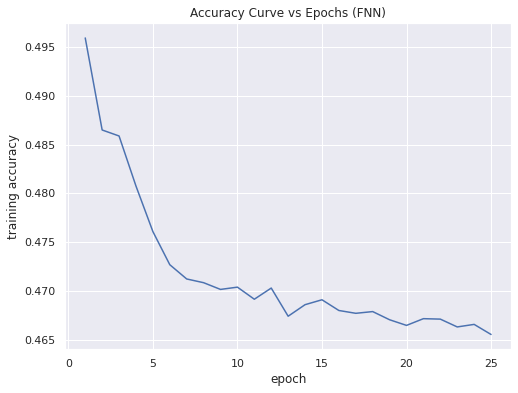

In [ ]:
plt.plot(range(1, len(acc_lst)+1), acc_lst) # plot the accuracy vs epoch on training set
plt.title("Accuracy Curve vs Epochs (FNN)")
plt.xlabel("epoch")
plt.ylabel("training accuracy")
plt.show()

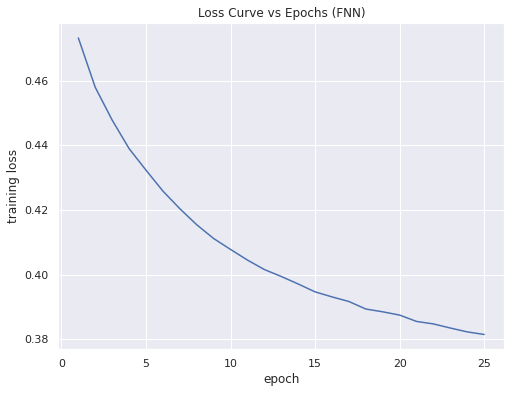

In [ ]:
plt.plot(range(1, len(loss_lst)+1), loss_lst) # plot the loss vs epoch on training set 
plt.title("Loss Curve vs Epochs (FNN)")
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.show()

In [ ]:
def test_model_fnn(net, criterion, test_loader, metric): # define a method to call test_loader for calculating test accuracy
  test_acc = 0
  test_loss = 0.
  for data, label in test_loader:
      with autograd.record():
          output = net(data)
          loss = criterion(output, label)
      metric.update(label.as_nd_ndarray(),output.as_nd_ndarray())
      name, acc = metric.get()
      test_acc += acc
      test_loss += loss.mean().as_np_ndarray().tolist()[0]
  testing_loss = test_loss / len(test_loader)
  testing_accuracy = test_acc / len(test_loader)
  return  testing_loss, testing_accuracy

# test model being trained
fnn_testing_loss, fnn_testing_accuracy = test_model_fnn(ffn_net, criterion, test_loader, metric)
print("test loss under FNN model without adaptive step size:",fnn_testing_loss)
print("test accuracy under FNN model without adaptive step size:",fnn_testing_accuracy)

test loss under FNN model without adaptive step size: 0.40265060479313025
test accuracy under FNN model without adaptive step size: 0.4593355991198958


The issue of above FNN model is reflected in the <b>Loss/Accuracy Curve vs Epochs</b> graph. Whilst the training loss is decreasing, the training accuracy is decreasing as well. This phenomenon insinuates that the model is getting more confident about the right predictions it made while it continues to make more mistakes on predictions overall. It may caused by the model fails to learn well from the instances that it misclassified before.

At first, we hypothesize that it may due to the insufficient number of epochs to train. Nonetheless, the simultaneous decrease of training accuracy and training loss persists when we set epochs to 500. Then we realize this may due to the fixed learning rate after consulting Prof.Zach. Therefore, we carry out an FNN with adaptive step size, also with a validation set. Scikit-learn has an established MLPClassfier toolkit that meets exactly what we need. The following is the implementation with parameters setting as:


*   activation function: relu
*   learning rate: initialized with 0.001, adaptively updates itself while training
*   validation set: 1/10 of the whole training dataset
*   stop condition: when the latest consecutive 10 epochs of training doesn't improve the validation score more than 1e-4.





In [ ]:
from sklearn.neural_network import MLPClassifier
fnn_clf = MLPClassifier(hidden_layer_sizes= (100,30,),
                        activation = "relu",
                        solver = "adam",
                        shuffle = True,
                        verbose = True, # set true to print training process
                        learning_rate = "adaptive",
                        early_stopping = True,
                        validation_fraction = 0.1,
                        )

fnn_clf.fit(x_train.values, y_train.to_numpy().ravel())

Iteration 1, loss = 0.50453476
Validation score: 0.775544
Iteration 2, loss = 0.45385701
Validation score: 0.783640
Iteration 3, loss = 0.42901413
Validation score: 0.797599
Iteration 4, loss = 0.40769985
Validation score: 0.801228
Iteration 5, loss = 0.38875756
Validation score: 0.811930
Iteration 6, loss = 0.37160529
Validation score: 0.811372
Iteration 7, loss = 0.35785539
Validation score: 0.819468
Iteration 8, loss = 0.34581306
Validation score: 0.824028
Iteration 9, loss = 0.33625945
Validation score: 0.831379
Iteration 10, loss = 0.32483145
Validation score: 0.828122
Iteration 11, loss = 0.31597540
Validation score: 0.837242
Iteration 12, loss = 0.30656487
Validation score: 0.837614
Iteration 13, loss = 0.30091531
Validation score: 0.840406
Iteration 14, loss = 0.29319653
Validation score: 0.842546
Iteration 15, loss = 0.28578824
Validation score: 0.844407
Iteration 16, loss = 0.28189282
Validation score: 0.849060
Iteration 17, loss = 0.27668461
Validation score: 0.849246
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 30),
              learning_rate='adaptive', verbose=True)

In [ ]:
# get test accuracy
fnn_clf_train_acc = fnn_clf.score(x_train.values,y_train.to_numpy().ravel())
fnn_clf_test_acc = fnn_clf.score(x_test.values,y_test.to_numpy().ravel())
print("train accuracy under FNN model + adaptive step size:",fnn_clf_train_acc)
print("test accuracy under FNN model + adaptive step size:",fnn_clf_test_acc)

train accuracy under FNN model + adaptive step size: 0.9448911222780569
test accuracy under FNN model + adaptive step size: 0.8973013214219244


## 4.3 Wait Days Analysis



From our data, we know that some applicants waited more than 10 years to get the a response, while some other applicants only waited a couple of days. So in this section, we want to explore the ```wait_days``` column to see what are some factors that could affect the response time.

We'll fit a LASSO model and examine the coefficients.




In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# check if wait time is all > 0
# Only include denied and certified/ certified expired
perm_df = pd.read_csv("/content/perm_full4.csv")
perm_reg_df = perm_df.loc[(perm_df['status'] == 'Denied') | (perm_df['status'] == 'Certified')| (perm_df['status'] == 'Certified-Expired')] 
# perm_reg_df[perm_reg_df["wait_days"] < 0]

In [ ]:
# one-hot encoding
perm_reg_df["wage_ratio"] = perm_reg_df["prop_yearly"]/ perm_reg_df["pw_yearly"] # get prop/pw ratio
perm_reg_df[["employee_size"]] = perm_reg_df["employee_size"].map(lambda x: np.log(1 + x)) # employee_size take log
perm_reg_df[["ownership"]] = perm_reg_df["ownership"].map({"Y":1,"N":0})
perm_reg_df[["wait_days"]] = perm_reg_df["wait_days"].map(lambda x: np.log(1 + x)) # wait_days take log
selected_col =['employee_size','ownership','skill_level',"curr_visa","education", "pw_yearly","wage_ratio","received_month","work_state_cleaned","industry_name", "status"]
labels_reg = perm_reg_df[['wait_days']]
features = perm_reg_df[selected_col]
features_reg = pd.get_dummies(features, columns = ['skill_level',"curr_visa","education","received_month","work_state_cleaned","industry_name", "status"], drop_first = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_reg, labels_reg, test_size=0.2, random_state=143)

In [ ]:
#standard scale the data
standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(X_train)
x_test_scaled = standard_scaler.transform(X_test)

In [ ]:
lasso_model = Lasso(alpha=0.001).fit(x_train_scaled, y_train)

In [ ]:
y_pred_test = lasso_model.predict(x_test_scaled)
y_pred_train = lasso_model.predict(x_train_scaled)
mean_squared_error(y_test, y_pred_test), mean_squared_error(y_train, y_pred_train)

(0.23440170041884678, 0.2341963355067928)

MSE looks okay. Let's now take a look at the coefficients - 

In [ ]:
sort_coef = sorted(zip(lasso_model.coef_, features_reg), key=lambda x: x[0])
lasso_coef = pd.DataFrame(sort_coef, columns = ['coef','feature'])
lasso_coef.head(9)
#lasso_coef[lasso_coef["feature"] == "received_month_12"]

,coef,feature
0,-0.085002,received_month_6
1,-0.080526,received_month_5
2,-0.066200,received_month_7
3,-0.058778,received_month_8
4,-0.044414,received_month_4
5,-0.036789,received_month_3
6,-0.027228,employee_size
7,-0.018192,received_month_2
8,-0.017405,work_state_cleaned_Texas



*   From the table above, we can see that ```received_month``` seems to be the most important factor. This is actually caused by the way US Department of Labor presents the yearly data, since a fiscal year is different from the actual calendar year. (See 4.2.3 explanation of data truncation).
*   We can see that ```employee_size``` matters. Employees working for a larger companies tend to receive the result sooner.
*   Also, people who's working in Texas seem to wait less time than other states.



## 4.4 Special Skills Analysis

As MCIT students, most of us have undergraduate degrees and backgrounds in fields other than computer science and believe that information technology is an essential skiil to have nowadays. Not only for IT related jobs like software engineers and machine learning engineers, CS skills can be very useful in other industries like finance and healthcare, to perform quantitative analysis on big data and to increace efficiency.

In our data, there is a "special skills" column that includes text data describing job related requirements for the job opportunity. So we want to dig into the text and examine one question in this section - For non-CS jobs, would there be a difference in wage between people without CS-related special skills and people with those skills? 

First, let's draw a word cloud for all jobs and see what are some keywords for `special skills`

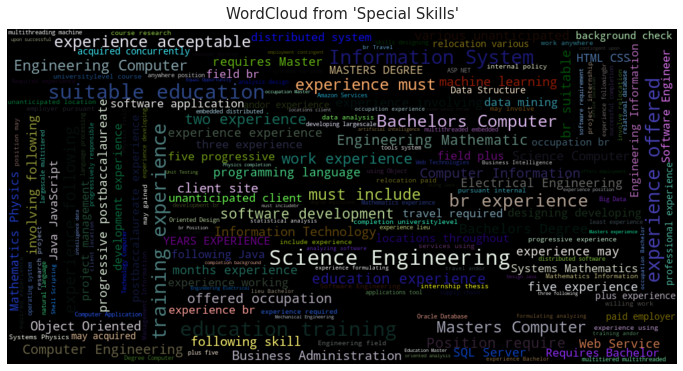

In [ ]:
from wordcloud import WordCloud, STOPWORDS
# STROPWORDS is a set of commonly seen stopwords
skills_df = perm_df[perm_df["special_skills"] != "Undisclosed"]
text_all_skills = " ".join(skills_df['special_skills']) # join all skill description as a string
# exclude stopwords in English and manually added "br" that are "meaningless" to analyze desired skills
stops = list(STOPWORDS) + ["br","Must","field","related","degrees","degree","foreign","equivalent","years","year","Employer", "will", "job","jobs", "one",  "accept", "combination"]
text_all_skills_cleaned = ' '.join([token for token in text_all_skills.split() if token not in stops])
# generate a word cloud image
wordcloud = WordCloud(width=1000, height=500, max_font_size=40).generate(text_all_skills_cleaned)
# display the generated image:
plt.figure(figsize=(12,8))
plt.tight_layout(pad=0)
plt.title("WordCloud from 'Special Skills'", fontsize = 15, pad=10, loc="center")
plt.imshow(wordcloud.recolor(color_func=cust_color_func, random_state=2), interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that some keywords are *Experience, Computer Science, Science, Engineering, Information System, suitable education etc.* It seems that a lot of the words are related to computer science field. 

Let's now separate CS jobs and non-CS jobs and see the top words.




In [ ]:
# Filter people who reported special_skills
# Note: SOC code for computer/data/IT related jobs starts with "15"
cs_df = perm_df[perm_df["special_skills"] != "Undisclosed"]
cs_df = cs_df[cs_df.soc_code.str.startswith("15") == True]
non_cs_df = perm_df[perm_df["special_skills"] != "Undisclosed"]
non_cs_df =  non_cs_df[non_cs_df.soc_code.str.startswith("15") == False]

In [ ]:
len(cs_df)

102252

In [ ]:
# get most frequent words in "special skills" for people in Computer Science category
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
skill_list_cs = cs_df["special_skills"].tolist()
skill_list_non_cs = non_cs_df["special_skills"].tolist()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenized_content(content):
  return [w for w in nltk.word_tokenize(content) if w.isalpha() and w.lower() not in stopwords]

In [ ]:
# TODO: Tokenize and flatten
skill_tokens_cs = [tokenized_content(i) for i in skill_list_cs]
skill_tokens_cs = [item for sublist in skill_tokens_cs for item in sublist]
skill_tokens_non_cs = [tokenized_content(i) for i in skill_list_non_cs]
skill_tokens_non_cs = [item for sublist in skill_tokens_non_cs for item in sublist]

In [ ]:
# get the top 25 words
from collections import Counter
most_common_skills_cs = Counter(skill_tokens_cs).most_common(25)
most_common_skills_non_cs = Counter(skill_tokens_non_cs).most_common(25)

In [ ]:
most_common_skills_cs

[('experience', 237507),
 ('br', 135561),
 ('years', 110001),
 ('related', 102754),
 ('Computer', 98662),
 ('degree', 89420),
 ('Engineering', 72274),
 ('Science', 70401),
 ('equivalent', 62742),
 ('field', 62375),
 ('C', 58349),
 ('foreign', 54606),
 ('year', 47967),
 ('following', 46446),
 ('Must', 45076),
 ('Bachelors', 43926),
 ('Information', 42563),
 ('education', 42348),
 ('software', 42123),
 ('one', 41472),
 ('Java', 39788),
 ('using', 38773),
 ('Systems', 38475),
 ('Masters', 37759),
 ('development', 36771)]

In [ ]:
most_common_skills_non_cs

[('experience', 87484),
 ('br', 55716),
 ('years', 43347),
 ('related', 36029),
 ('degree', 30046),
 ('Engineering', 24938),
 ('field', 19098),
 ('equivalent', 18591),
 ('including', 18197),
 ('foreign', 16514),
 ('Must', 16321),
 ('design', 16266),
 ('analysis', 15274),
 ('management', 14677),
 ('Bachelors', 14068),
 ('must', 14026),
 ('Experience', 13859),
 ('education', 13732),
 ('year', 13176),
 ('accept', 12336),
 ('Masters', 11924),
 ('training', 11702),
 ('data', 11097),
 ('Computer', 10890),
 ('Science', 10802)]

There are a lot of words like "experience", "year", "related" and 
"degree" that are commonly used in skillset description but are not specific to computer science field. Similar to what we did in HW2, let's also generate a list for non-CS jobs and see the difference.

In [ ]:
# Find the difference between counters and get the most common words
cs_counter, non_cs_counter = Counter(), Counter()
for word in skill_tokens_cs:
  cs_counter[word] += 1
  non_cs_counter[word] -= 1
for word in skill_tokens_non_cs:
  cs_counter[word] -= 1
  non_cs_counter[word] += 1

distinct_cs_most_common = cs_counter.most_common(50)

In [ ]:
distinct_cs_most_common

[('experience', 150023),
 ('Computer', 87772),
 ('br', 79845),
 ('related', 66725),
 ('years', 66654),
 ('Science', 59599),
 ('degree', 59374),
 ('C', 54418),
 ('Engineering', 47336),
 ('equivalent', 44151),
 ('field', 43277),
 ('Information', 39378),
 ('Java', 38495),
 ('foreign', 38092),
 ('following', 35871),
 ('Systems', 34819),
 ('year', 34791),
 ('one', 34736),
 ('software', 34640),
 ('SQL', 32993),
 ('Bachelors', 29858),
 ('using', 28875),
 ('Must', 28755),
 ('education', 28616),
 ('development', 28166),
 ('Mathematics', 27469),
 ('Masters', 25835),
 ('job', 24940),
 ('data', 24465),
 ('offered', 23817),
 ('accept', 23518),
 ('Employer', 22987),
 ('combination', 22250),
 ('systems', 21841),
 ('Oracle', 21833),
 ('suitable', 21757),
 ('training', 19465),
 ('unanticipated', 19119),
 ('Experience', 19111),
 ('Software', 18687),
 ('applications', 18098),
 ('Data', 17690),
 ('occupation', 17368),
 ('locations', 17209),
 ('Python', 17198),
 ('position', 17122),
 ('programming', 16564)

Much better! A lot of the words listed here are CS-related. We can see some popular programming languages mentioned here are C, Java, SQL, Python (ranked by counts).

Let's use some of these words to filter our data set and examine the question we asked in the beginning of this section.


In [ ]:
non_cs_df["CS_skill"]= non_cs_df["special_skills"].str.contains('CS') | non_cs_df["special_skills"].str.contains('Computer Science') \
|non_cs_df["special_skills"].str.contains('computer science')| non_cs_df["special_skills"].str.contains('computer science') |\
non_cs_df["special_skills"].str.contains('Java') | non_cs_df["special_skills"].str.contains('Python') | non_cs_df["special_skills"].str.contains('SQL')\
|non_cs_df["special_skills"].str.contains('Oracle') |non_cs_df["special_skills"].str.contains('programming') |non_cs_df["special_skills"].str.contains('Programming') \
|non_cs_df["special_skills"].str.contains('Data') |non_cs_df["special_skills"].str.contains('data')

In [ ]:
# exclude "11-3021" - Computer and Information Systems Managers, which is not in CS big category but clearly a CS job
non_cs_df = non_cs_df[non_cs_df["soc_code"] != "11-3021"]

In the following part, we'll use statsmodel package instead of sklearn to do a linear regression (statsmodel package can show us p-value but sklearn cannot).

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# one hot encoding
non_cs_df[["employee_size"]] = non_cs_df["employee_size"].map(lambda x: np.log(1 + x)) # employee_size take log
non_cs_df[["ownership"]] = non_cs_df["ownership"].map({"Y":1,"N":0})
non_cs_df[["CS_skill"]] = non_cs_df["CS_skill"].map({True:1,False:0})

In [ ]:
selected_col =['employee_size','ownership','skill_level',"education","work_state_cleaned","industry_name", "CS_skill"]
labels_cs = non_cs_df[["pw_yearly"]]
features = non_cs_df[selected_col]
features_cs = pd.get_dummies(features, columns = ['skill_level',"education","work_state_cleaned","industry_name"], drop_first = True)

In [ ]:
# Fit and summarize OLS model
mod = sm.OLS(labels_cs, features_cs)
res = mod.fit()
#print(res.summary())

In [ ]:
# Bonferroni correction with degree of freedom = 1135
res.pvalues["CS_skill"] < (0.05/1135)

True

After fitting the model, we can see that p-value with Bonferroni correction is less than the the threshold, which means that we can eliminate all other potential confounders such as education, work location, work industry, company's size etc. and confirm our assumption - there's a difference in wage between people with CS related skills and people without CS related skills in non-CS fields(with higher wage for people with CS skills). For MCIT students, it's a good sign that CS skills will indeed help us in both CS and non-CS industries!


# Section 5: Conclusion


In this project, we used PERM application data for the past several years and performed data integration, data cleaning and modeling. Exploring the whole pipeline of turning raw data to machine learning models using real-life data is quite challenging but also very intriguing. We not only applied a significant amount of knowledge learned in class (eg. data cleaning, data visualization, classification, regression, neural networks etc.), but also took the step to try some other interesting tools (eg. tableau for data visualization, gradient boosting tree, SVMs etc.) 

Some future directions for future researchers to explore:
*   Dive down into individual states / industries to uncover any state-specific / industry-specific bias. Our data shows that looking at some of the commonly emphasized variables such as wage, current visa status, home country would not be sufficient in making a sound guess on whether a PERM application would be approved.
*   Enlarge the data size to include more years of records. A larger data size can provide an ideal window to instrument time series analysis, which can potentially track down some interesting trends of the features.
*   Examine changes in approval criteria across different administrations (Obama vs Trump vs Biden // Democrat vs Republican).